## Useful Functions

In [2]:
def func_plot(y,x=None,xlabel=None,ylabel=None,show_mean_x=0,show_mean_y=0,ylim=None,xlim=None):
    if(hasattr(y, 'to_numpy')):
        y = y.to_numpy()
        
    fig, ax = plt.subplots(figsize=(20, 10))
    if x is None:
        x = range(0,np.size(y))
    elif(hasattr(x, 'to_numpy')):
        x = x.to_numpy()
        
    
    ax.scatter(x,y,color='black')
    if(show_mean_y!=0): plt.axhline(np.mean(y), c='blue', lw=2, linestyle='-.')
    if(show_mean_x!=0): plt.plot(np.mean(x), c='blue', lw=2, linestyle='-.')
        
    if xlabel is not None:plt.xlabel(xlabel,fontsize=20)
    if ylabel is not None:plt.ylabel(ylabel,fontsize=20)
    
    if ylim is None:ylim=[np.min(y)-1,np.max(y)+1]
    if xlim is None:xlim=[np.min(x)-1,np.max(x)+1]
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.tick_params(axis='both',labelsize=20)

In [3]:
def compute_inertia(Prox_mat,method_name=None,nb_cluster_max=10):
    if(method_name is None):method_name='single'
    
    N = np.size(Prox_mat,0)
    if(nb_cluster_max>N):nb_cluster_max = N
    
    output_pdist = sc_dist.squareform(Prox_mat)
    output_linkage = sc.linkage(output_pdist, method=method_name)
    
    inertia = np.zeros([nb_cluster_max])
    for i in range(nb_cluster_max):
        clust = sc.cut_tree(output_linkage,n_clusters=(i+1))
        count_clust = np.zeros(i+1)
        for j in range((i+1)):
            count_clust[j] = np.sum(clust==j)
            
        inertia[i] = np.max(count_clust)
    
    return inertia

In [4]:
def Euclidean_dist(x1,x2):
    if(hasattr(x1, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        x1 = x1.to_numpy() ## If not Numpy type: we assume this is a dataframe.
        x2 = x2.to_numpy() ## If not Numpy type: we assume this is a dataframe.
    
        
    if(np.size(x1)!=np.size(x2)): ## Checking dimension 
        sys.exit("Dimension issue")
    if(np.ndim(x1)<=1): ## If one dimensional array: Euclidean over the rows --> scalar
        euc_dist = np.sqrt(np.sum((x1-x2)**2))
    else: ## Nxd array --> Euclidean distance for each row (sum over the columns)
        euc_dist = np.sqrt(np.sum((x1-x2)**2,axis=1))
        
    return euc_dist


In [5]:
def dist_per_cluster(y,max_k,replic=5):
    dist = np.zeros([max_k])
    for k in range(max_k):## For each number of cluster: run a K-means algorithm and store the distance
        output = Kmeans_algo(y,k+1,replic)
        dist[k] = output[2]
    
    return dist

In [6]:
import numpy as np

def Kmeans_algo(y, nb_K=2, replic=5, random_state=None):
    
    if hasattr(y, 'to_numpy'):  # Checking if the input is Numpy type or DataFrame type 
        y = y.to_numpy()
     
    N = len(y)  # Number of observations
    if len(np.shape(y)) == 1:  # If dimension=1, reshape to Nx1 matrix
        y = np.array(y, ndmin=2).transpose()
    
    dimension = np.shape(y)[1]

    ### Fix random state if provided
    if random_state is not None:
        np.random.seed(random_state)

    ### Initialisation of the K-means algorithm
    mu = np.zeros([nb_K, dimension])
    dist = np.zeros([N, nb_K])
    idx_save = np.zeros([N, 500])  # Save all partitions found by the K-means algorithm

    if nb_K > 1:  # Initialization requires a partition
        nb_init = 20
        dist_start = np.zeros(nb_init)
        idx_start = np.zeros([N, replic])

        for i in range(replic):
            prob = ((i+1)) / (2 * replic)
            idx_prop = np.zeros([N, nb_init], dtype=int)

            for j in range(nb_init):
                idx_prop[:, j] = np.sum(np.random.rand(N, nb_K) > prob, axis=1).astype(int)  # Simulation
                
                for k in range(nb_K):  # Compute the mean of each cluster
                    if np.sum(idx_prop[:, j] == k) > 0:
                        mu[k, :] = np.mean(y[idx_prop[:, j] == k, :], axis=0)
                
                for k in range(nb_K):
                    dist[:, k] = Euclidean_dist(y, np.tile(mu[k, :], [N, 1]))
                
                dist_start[j] = np.sum(np.min(dist, axis=1) ** 2)

            idx_start[:, i] = idx_prop[:, np.argmin(dist_start)]        

    for i in range(replic):  # Run K-means multiple times to avoid local minima
        mu = np.zeros([nb_K, dimension])
        
        if nb_K > 1:
            idx = idx_start[:, i]
        else:
            idx = np.zeros(N)

        ### K-means algorithm
        convergence = 0
        idx_save[:, 0] = idx
        count = 0

        while convergence == 0:
            for k in range(nb_K):  # Compute means of clusters
                if np.sum(idx == k) > 0:
                    mu[k, :] = np.mean(y[idx == k, :], axis=0)

            idx_prev = idx.copy()
            for k in range(nb_K):
                dist[:, k] = Euclidean_dist(y, np.tile(mu[k, :], [N, 1]))

            idx = np.argmin(dist, axis=1)  # Assign to nearest cluster

            if np.sum(idx == idx_prev) == N:  # Check convergence
                convergence = 1

            count += 1
            idx_save[:, count] = idx  # Save partition

        ### Find the best clustering result
        sq_dist = sum(np.sum(dist[idx == k, k] ** 2) for k in range(nb_K))

        if i == 0:
            idx_all = idx_save[:, :count + 1]
            idx_best = idx
            sq_dist_best = sq_dist
        elif sq_dist < sq_dist_best:
            idx_all = idx_save[:, :count + 1]
            idx_best = idx
            sq_dist_best = sq_dist

    return idx_best, idx_all, sq_dist_best


In [7]:
def Mahanalobis_dist(data,mu=None,cov=None):
    if(hasattr(data, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        y = np.array(data.to_numpy(),ndmin=2) ## If not Numpy type: we assume this is a dataframe.
    else:
        y = data
        
    if(np.ndim(y)==1):
        if cov is None:sys.exit('Covariance should be provided')
        
        if mu is None:sys.exit('mu should be provided')
        
        if(np.size(y)==1):
            mana = (y-mu)**2/cov ## Univariate
        else:
            inv_covmat = np.linalg.inv(cov)
            y_mu = np.array(y - mu,ndmin=2) ## array 1xK
            mana = np.matmul(y_mu,np.matmul(inv_covmat,y_mu.transpose()))
    else:
        if(np.size(y,0)<np.size(y,1)):## Ensure that the array is of size NxK
            y = y.transpose()
        
        if cov is None:
            cov = np.cov(y.transpose())
        
        if mu is None:
            mu = np.mean(y,axis=0)
        
        N = np.size(y,0)
        y_mu = y - np.tile(mu,[N,1]) ## to perform matrix multiplication
        inv_covmat = np.linalg.inv(cov)
        
        mana = np.zeros([N])
        for i in range(N):
            mana[i] = np.sqrt(np.matmul(y_mu[i,:],np.matmul(inv_covmat,y_mu[i,:]))) 
            
        
    return mana

In [8]:
def Mahanalobis_dist2(data,mu=None,cov=None):
    if(hasattr(data, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        y = np.array(data.to_numpy(),ndmin=2) ## If not Numpy type: we assume this is a dataframe.
    else:
        y = data
        
    if(np.ndim(y)==1):
        if cov is None:sys.exit('Covariance should be provided')
        
        if mu is None:sys.exit('mu should be provided')
        
        if(np.size(y)==1):
            mana = (y-mu)**2/cov ## Univariate
        else:
            inv_covmat = np.linalg.pinv(cov)
            y_mu = np.array(y - mu,ndmin=2) ## array 1xK
            mana = np.matmul(y_mu,np.matmul(inv_covmat,y_mu.transpose()))
    else:
        if(np.size(y,0)<np.size(y,1)):## Ensure that the array is of size NxK
            y = y.transpose()
        
        if cov is None:
            cov = np.cov(y.transpose())
        
        if mu is None:
            mu = np.mean(y,axis=0)
        
        N = np.size(y,0)
        y_mu = y - np.tile(mu,[N,1]) ## to perform matrix multiplication
        inv_covmat = np.linalg.pinv(cov)
        
        mana = np.zeros([N])
        for i in range(N):
            mana[i] = np.sqrt(np.matmul(y_mu[i,:],np.matmul(inv_covmat,y_mu[i,:]))) 
            
        
    return mana

In [9]:
def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
    
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    senter : Significance Level to be Selected in Forward Selection (default: 0.05)\n
    sstay : Significance Level to be Stayed in Backward Elimination (default: 0.05)\n
  

    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    

    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    

    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """  
    
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    
    # Check if there are any categorical columns and if they need transformation
    categorical_columns = dtypes[dtypes == 'object'].index.tolist()
    
    # Skip dummy conversion if there are no categorical columns (already processed)
    if len(categorical_columns) == 0:
        print("No categorical variables found. Skipping dummy transformation.")
    else:
        if varchar_process == "drop":
            X = X.drop(columns=categorical_columns)
            print("Character Variables (Dropped):", categorical_columns)
        elif varchar_process == "dummy":
            X = pd.get_dummies(X, drop_first=False)
            print("Character Variables (Dummies Generated):", categorical_columns)
        elif varchar_process == "dummy_dropfirst":
            X = pd.get_dummies(X, drop_first=True)
            print("Character Variables (Dummies Generated, First Dummies Dropped):", categorical_columns)
        else:
            # Default case if no valid option is provided
            X = pd.get_dummies(X, drop_first=True)
            print("Character Variables (Dummies Generated, First Dummies Dropped):", categorical_columns)
    
    # Add intercept (constant) term
    X["intercept"] = 1
    
    # Re-arrange columns so that intercept comes first
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]  # Move the last column (intercept) to the front
    X = X[cols]
    
    return X
    

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    

            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):
                
                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])

 
                for l in cols_backward:
                    pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
                    
                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:
                    
                    
                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n") 
                        
                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                    
                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                           
                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"     
        
           
                else:
                    print("break : No need to Backward Elimination")
                    break
            
            
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
            
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)
    

    iterations_log += "\nFinal Selection and Model Statistics\n"
    
    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m]) 
           
    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log

In [10]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_excel(r"C:\Users\Hp\OneDrive - EDHEC\Documents\THESIS\Final database - Copie.xlsx")
data.head()

,Country,Population,Age standardized 3-year cancer survival rate,"Risk of developing cancer before the age of 75 years (cum, risk %)","Risk of dying from cancer before the age of 75 years (cum, risk %)",World Bank income level,GDP (current US$),Cancer death caused by Tobacco,Cancer death caused by Alcohol,Cancer caused by Infections,...,Pathology services,Bone marrow transplantation capacity,Palliative care availability: community/home-based care,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate
0,Algeria,45606480,0.424289,14.6,8.2,Lower-middle income (LMC),2.476262e+11,0.186,0.011,0.129,...,Generally available,Generally available,Generally not available,48,74.111641,0.75,0.075143,0.424832,9.831,14.877
1,Benin,13712828,0.293590,11.0,7.7,Lower-middle income (LMC),1.967605e+10,0.086,0.033,0.334,...,Generally not available,Generally not available,Generally not available,10,37.892559,0.00,0.064779,0.239401,1.305,6.003
2,Botswana,2675352,0.409095,11.8,7.1,Upper-middle income (UMC),1.939608e+10,0.146,0.106,0.304,...,Generally available,unknown,Generally available,67,55.179852,0.51,0.053200,0.446879,3.132,3.915
3,Burkina Faso,23251485,0.207794,13.9,11.1,Low income (LIC),2.032462e+10,0.060,0.074,0.331,...,Generally available,Generally not available,Generally not available,1,39.604561,0.00,0.025641,0.229265,3.306,2.958
4,Burundi,13238559,0.223301,13.4,10.6,Low income (LIC),2.642162e+09,0.098,0.086,0.338,...,Generally not available,Generally not available,Generally not available,4,41.460030,0.00,0.057083,0.181953,2.958,5.568


In [11]:
# Get all the columns

data.columns

Index(['Country', 'Population', 'Age standardized 3-year cancer survival rate',
       'Risk of developing cancer before the age of 75 years (cum, risk %)',
       'Risk of dying from cancer before the age of 75 years (cum, risk %)',
       'World Bank income level', 'GDP (current US$)',
       'Cancer death caused by Tobacco', 'Cancer death caused by Alcohol',
       'Cancer caused by Infections', 'Cancer caused by Obesity',
       'Cancer caused by UV', 'Cancer death caused by Occupational risks',
       'Probability of premature death from cancer per year',
       'Investment cost per capital in cancer (US $)',
       'Availability of population-based cancer registry (PBCR)',
       'Quality of external beam radiotherapy (rate per 10000 cancer patients)',
       'Quality of mammographs (rate per 10000 cancer patients)',
       'Quality of  CT scanners (rate per 10000 cancer patients)',
       'Quality of  MRI scaners (rate per 10000 cancer patients)',
       'Quality of PET or PET/C

In [12]:
# Get info on the dataframe

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 45 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Country                                                                                     127 non-null    object 
 1   Population                                                                                  127 non-null    int64  
 2   Age standardized 3-year cancer survival rate                                                127 non-null    float64
 3   Risk of developing cancer before the age of 75 years (cum, risk %)                          127 non-null    float64
 4   Risk of dying from cancer before the age of 75 years (cum, risk %)                          127 non-null    float64
 5   World Bank income level                    

## Pre-analysis

In [14]:
# Focus on the dependant variable
data["Age standardized 3-year cancer survival rate"].describe()

count    127.000000
mean       0.436117
std        0.137952
min        0.201253
25%        0.311438
50%        0.424289
75%        0.527022
max        0.763136
Name: Age standardized 3-year cancer survival rate, dtype: float64

The average Age standardized 3-year cancer survival rate survival is 43,61%

In [16]:
#Lung cancer
data["Lung Cancer AS 3-year survival rate"].describe()

count    127.000000
mean       0.140130
std        0.091881
min        0.005436
25%        0.069420
50%        0.116772
75%        0.178880
max        0.451735
Name: Lung Cancer AS 3-year survival rate, dtype: float64

In [17]:
#Colorectal cancer
data["Colorectal cancer AS 3-year survival rate"].describe()

count    127.000000
mean       0.421327
std        0.143822
min        0.014051
25%        0.325233
50%        0.443330
75%        0.506406
max        0.716345
Name: Colorectal cancer AS 3-year survival rate, dtype: float64

In [18]:
var_survival_rate = np.var(data["Age standardized 3-year cancer survival rate"], ddof = 1)
var_survival_rate

0.019030849918018435

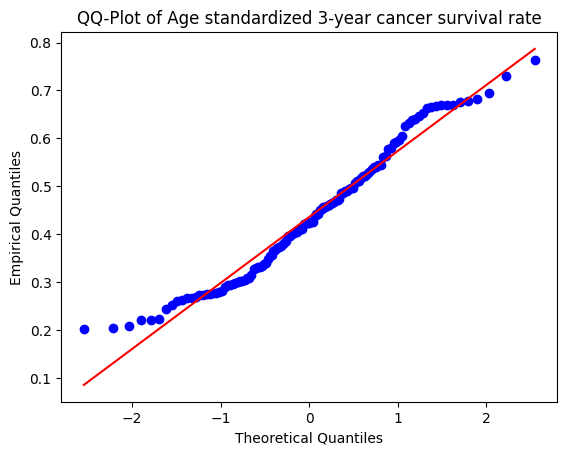

In [19]:
# QQ-Plot to assess wether Age standardized 3-year cancer survival rate follow a normal distribution

stats.probplot(data['Age standardized 3-year cancer survival rate'], dist="norm", plot=plt)
plt.title('QQ-Plot of Age standardized 3-year cancer survival rate')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.show()

The QQ-plot analysis reveals certain deviations from the diagonal. This indicates that the age-standardized survival rate (at 3 years) does not perfectly follow a normal distribution. We can justify this by the fact that cancer survival rate data are more likely to have an asymmetrical distribution. In the lower tail, we note that some points are very far from the diagonal, which could alert us to the presence of potential outliers (unusual cases where the survival rate is extremely low) that should be investigated further.

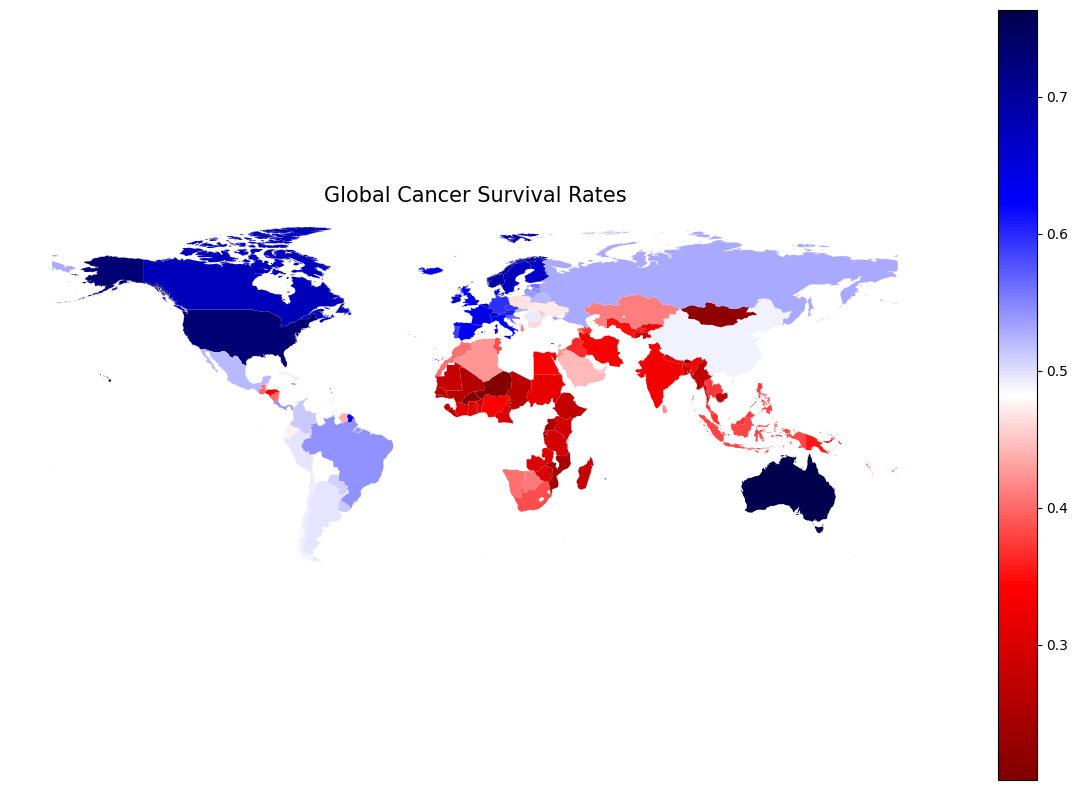

In [21]:
# Create a map to see the countries where the survival rate are low

import geopandas as gpd
import matplotlib.pyplot as plt

import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
world_map = gpd.read_file(r"C:\Users\Hp\Downloads\ne_10m_admin_0_countries.zip")

# Select the necessary columns
my_data = data[["Country","Age standardized 3-year cancer survival rate"]] 

# Merge the data based on country names
merged_data = world_map.merge(my_data, left_on='NAME', right_on='Country')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='Age standardized 3-year cancer survival rate', cmap='seismic_r', legend=True, ax=ax)

ax.axis('off')
plt.title('Global Cancer Survival Rates',fontsize=15)
plt.show()

The map reveals that many African and South Asian countries have relatively low age-standardized three-year cancer survival rates. In contrast, countries in the Americas, Europe, and Oceania exhibit higher survival rates.

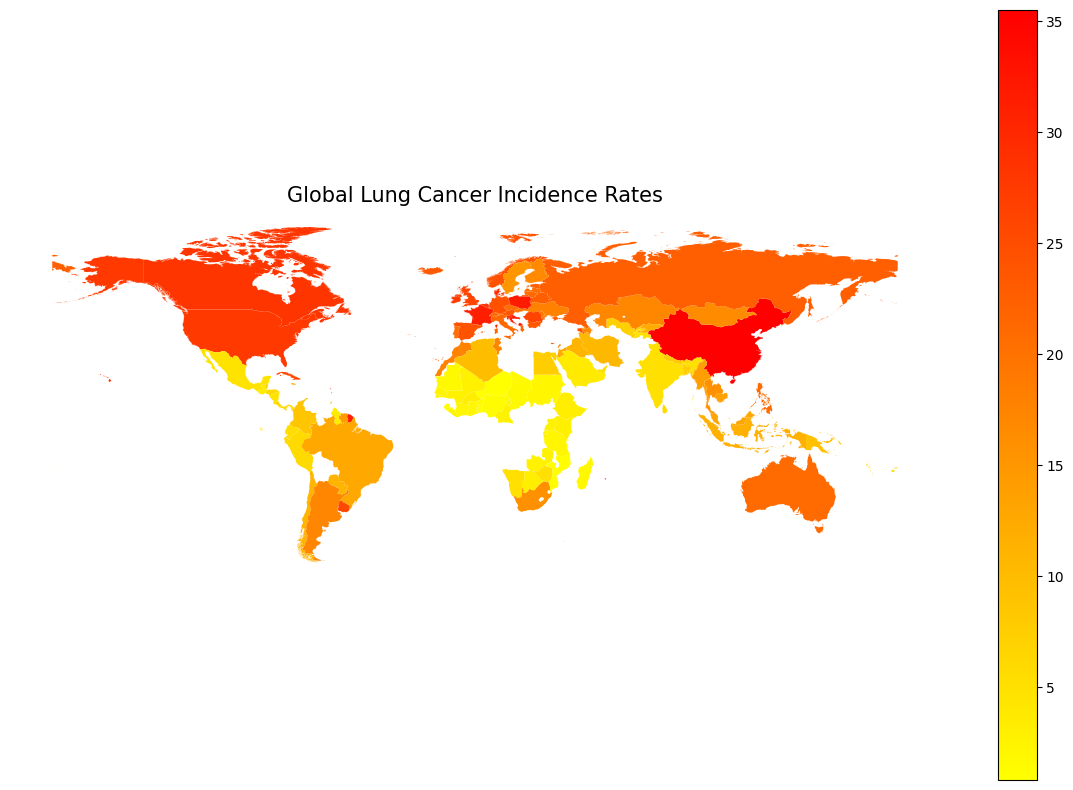

In [23]:
# Map for lung cancer incidence

# Select the necessary columns
my_data2 = data[["Country","Lung Cancer AS 3-year incidence rate"]] 

# Merge the data based on country names
merged_data = world_map.merge(my_data2, left_on='NAME', right_on='Country')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='Lung Cancer AS 3-year incidence rate', cmap='autumn_r', legend=True, ax=ax)

ax.axis('off')
plt.title('Global Lung Cancer Incidence Rates',fontsize=15)
plt.show()

The map highlights significantly high lung cancer incidence rates in North America, in Europe, in China and Australia while other regions have lower rates.

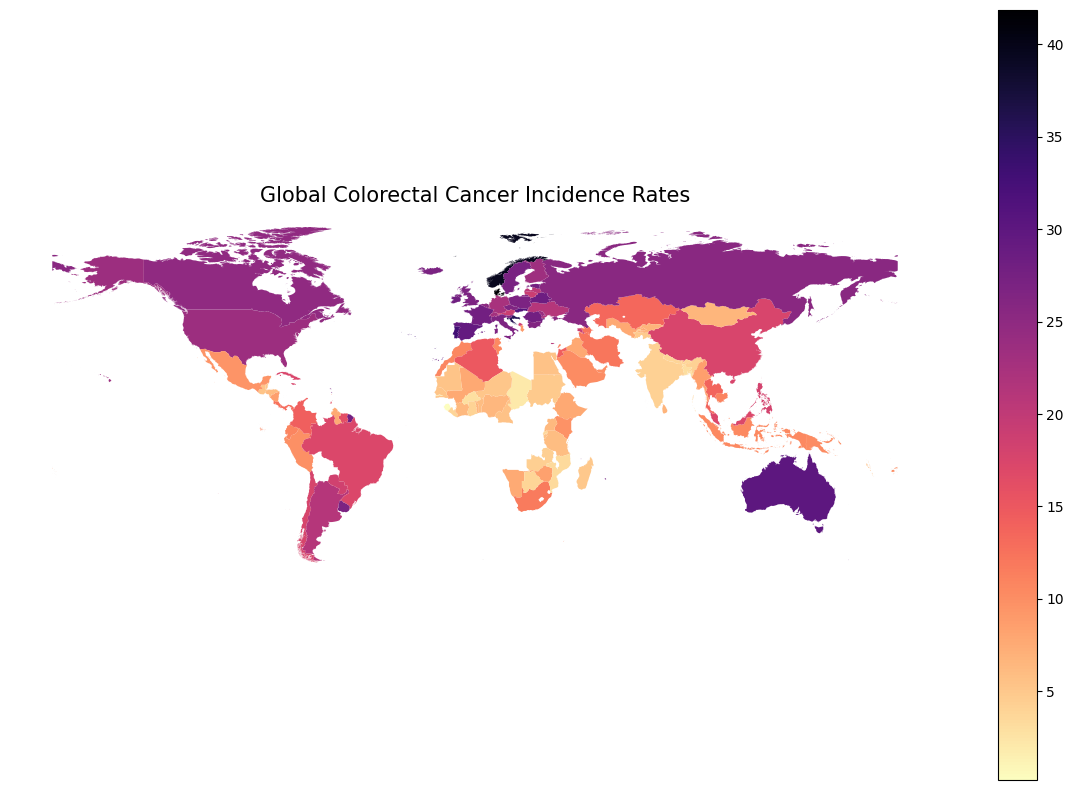

In [25]:
# Map for colorectal cancer incidence
# Select the necessary columns
my_data3 = data[["Country","Colorectal cancer AS 3-year incidence rate"]] 

# Merge the data based on country names
merged_data = world_map.merge(my_data3, left_on='NAME', right_on='Country')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.plot(column='Colorectal cancer AS 3-year incidence rate', cmap='magma_r', legend=True, ax=ax)

ax.axis('off')
plt.title('Global Colorectal Cancer Incidence Rates',fontsize=15)
plt.show()

The map shows that global colorectal AS incidence rate is extremely high in Europe, Australia, South America and some parts of South America especially in Uruguay and Argentina

## Findings

High-income regions report higher incidence rates of lung and colorectal cancer but achieve better survival outcomes due to advanced healthcare resources and early detection. In contrast, low-income regions have lower reported incidence rates due to limited diagnostics, yet many cases go undetected until advanced stages, resulting in poor survival rates. This shows that incidence rates mainly reflect the number of detected cases rather than healthcare effectiveness. To better assess cancer care quality and guide policy decisions, our study will use cancer survival rate as the dependent variable.

## Examining whether the trends observed in the maps remain consistent within clusters

### K-means clustering

#### Dealing with categorical variables (transform into dummy)


In [32]:
pd.set_option('future.no_silent_downcasting', True)

In [33]:
#Identify categorical variables
data.select_dtypes(include =['object']).columns

Index(['Country', 'World Bank income level',
       'Availability of population-based cancer registry (PBCR)',
       'Available staff in Ministry of Health (dedicated time to cancer research)',
       'Integrated NCD plan', 'NCCP (including cancer types)',
       'Cancer management guidelines',
       'Palliative care included in their operational, integrated NCD plan',
       'Pathology services', 'Bone marrow transplantation capacity',
       'Palliative care availability: community/home-based care'],
      dtype='object')

In [34]:
# World Bank income level
World_Bank_dummies = pd.get_dummies(data["World Bank income level"],prefix='World Bank income level',dtype=int)
World_Bank_dummies = World_Bank_dummies.drop(["World Bank income level_Low income (LIC)"],axis=1)

In [35]:
#Availability of population-based cancer registry (PBCR)
Availability_of_population_cancer_registry_dummies = pd.get_dummies(
    data["Availability of population-based cancer registry (PBCR)"],prefix='Availability of population-based cancer registry (PBCR)'
    ,dtype=int)
Availability_of_population_cancer_registry_dummies = Availability_of_population_cancer_registry_dummies.drop(['Availability of population-based cancer registry (PBCR)_unknown'],axis=1)

In [36]:
#Available staff in Ministry of Health (dedicated time to cancer research)
Available_staff_in_Ministry_of_Health_cancer_research_dummies = pd.get_dummies(
    data["Available staff in Ministry of Health (dedicated time to cancer research)"],
    prefix='Available staff in Ministry of Health (dedicated time to cancer research)'
    ,dtype=int)
Available_staff_in_Ministry_of_Health_cancer_research_dummies= Available_staff_in_Ministry_of_Health_cancer_research_dummies.drop(["Available staff in Ministry of Health (dedicated time to cancer research)_unknown"],axis=1)

In [37]:
#Integrated NCD plan
Integrated_NCD_plan_dummies = pd.get_dummies(
    data["Integrated NCD plan"],prefix='Integrated NCD plan'
    ,dtype=int)
Integrated_NCD_plan_dummies = Integrated_NCD_plan_dummies.drop(['Integrated NCD plan_unknown'],axis =1)

In [38]:
#NCCP (including cancer types)
NCCP_including_cancer_types_dummies = pd.get_dummies(data["NCCP (including cancer types)"],
                                                     prefix='NCCP (including cancer types)',dtype=int)
NCCP_including_cancer_types_dummies = NCCP_including_cancer_types_dummies.drop(['NCCP (including cancer types)_unknown'],axis =1)

In [39]:
#Cancer management guidelines
Cancer_management_guidelines_dummies = pd.get_dummies(data["Cancer management guidelines"],
                                                      prefix='Cancer management guidelines',dtype=int)
Cancer_management_guidelines_dummies = Cancer_management_guidelines_dummies.drop(['Cancer management guidelines_unknown'],axis=1)

In [40]:
#Palliative care included in their operational, integrated NCD plan
Palliative_care_included_in_operational_integrated_NCD_plan_dummies = pd.get_dummies(
    data["Palliative care included in their operational, integrated NCD plan"],
    prefix='Palliative care included in their operational, integrated NCD plan',dtype=int)
Palliative_care_included_in_operational_integrated_NCD_plan_dummies = Palliative_care_included_in_operational_integrated_NCD_plan_dummies.drop(["Palliative care included in their operational, integrated NCD plan_unknown"],axis=1)

In [41]:
#Pathology services
Pathology_services_dummies = pd.get_dummies(data["Pathology services"],
                                            prefix='Pathology services',dtype=int)
Pathology_services_dummies = Pathology_services_dummies.drop(['Pathology services_unknown'],axis=1)

In [42]:
# Bone marrow transplantation capacity
Bone_marrow_transplantation_capacity_dummies = pd.get_dummies(data["Bone marrow transplantation capacity"],
                                                              prefix='Bone marrow transplantation capacity',dtype=int)
Bone_marrow_transplantation_capacity_dummies = Bone_marrow_transplantation_capacity_dummies.drop(['Bone marrow transplantation capacity_unknown'],axis =1)

In [43]:
#Palliative care availability: community/home-based care
Palliative_care_availability_community_home_based_care_dummies = pd.get_dummies(
    data["Palliative care availability: community/home-based care"],
    prefix='Palliative care availability: community/home-based care',dtype=int)
Palliative_care_availability_community_home_based_care_dummies = Palliative_care_availability_community_home_based_care_dummies.drop(["Palliative care availability: community/home-based care_unknown"],axis=1)

In [44]:
df = data.drop(data[['World Bank income level',
       'Availability of population-based cancer registry (PBCR)',
       'Available staff in Ministry of Health (dedicated time to cancer research)',
       'Integrated NCD plan', 'NCCP (including cancer types)',
       'Cancer management guidelines',
       'Palliative care included in their operational, integrated NCD plan',
       'Pathology services', 'Bone marrow transplantation capacity',
       'Palliative care availability: community/home-based care']], axis = 1)
df

,Country,Population,Age standardized 3-year cancer survival rate,"Risk of developing cancer before the age of 75 years (cum, risk %)","Risk of dying from cancer before the age of 75 years (cum, risk %)",GDP (current US$),Cancer death caused by Tobacco,Cancer death caused by Alcohol,Cancer caused by Infections,Cancer caused by Obesity,...,MPOWER measures fully implemented and achieved,"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",Public cancer centres per 10000 cancer patients,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate
0,Algeria,45606480,0.424289,14.6,8.2,2.476262e+11,0.186,0.011,0.129,0.033,...,0,3,2.8,48,74.111641,0.75,0.075143,0.424832,9.831,14.877
1,Benin,13712828,0.293590,11.0,7.7,1.967605e+10,0.086,0.033,0.334,0.014,...,2,0,1.2,10,37.892559,0.00,0.064779,0.239401,1.305,6.003
2,Botswana,2675352,0.409095,11.8,7.1,1.939608e+10,0.146,0.106,0.304,0.020,...,0,3,10.2,67,55.179852,0.51,0.053200,0.446879,3.132,3.915
3,Burkina Faso,23251485,0.207794,13.9,11.1,2.032462e+10,0.060,0.074,0.331,0.004,...,2,2,3.4,1,39.604561,0.00,0.025641,0.229265,3.306,2.958
4,Burundi,13238559,0.223301,13.4,10.6,2.642162e+09,0.098,0.086,0.338,0.004,...,1,0,1.0,4,41.460030,0.00,0.057083,0.181953,2.958,5.568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Uzbekistan,36194172,0.348645,12.3,8.2,1.015918e+11,0.138,0.078,0.213,0.030,...,0,3,6.3,12,74.841270,0.28,0.147596,0.445059,7.308,7.830
123,Australia,26256970,0.763136,41.2,8.4,1.728057e+12,0.207,0.071,0.037,0.051,...,4,3,1.0,11043,86.778778,1.12,0.329411,0.701833,20.967,30.102
124,Fiji,936375,0.422486,17.2,10.1,5.442047e+09,0.143,0.040,0.212,0.055,...,1,2,19.7,121,58.247059,0.00,0.028468,0.345077,5.916,10.005
125,Papua New Guinea,10329931,0.353775,18.7,12.0,3.072924e+10,0.184,0.042,0.229,0.022,...,1,2,0.8,46,30.394680,0.08,0.099607,0.356092,9.309,10.179


#### Categorize variables with same scale and description

In [46]:
category = df

##### Category 1 : Cancer risks factors

In [48]:
# Cancer risks factors
category['Cancer risks factors'] = np.mean(df[['Risk of developing cancer before the age of 75 years (cum, risk %)',
       'Risk of dying from cancer before the age of 75 years (cum, risk %)','Cancer death caused by Tobacco', 'Cancer death caused by Alcohol',
       'Cancer caused by Infections', 'Cancer caused by Obesity',
       'Cancer caused by UV', 'Cancer death caused by Occupational risks','Probability of premature death from cancer per year']], axis = 1)
category['Cancer risks factors']

0      2.583578
1      2.177356
2      2.220811
3      2.871422
4      2.790789
         ...   
122    2.345278
123    5.672711
124    3.093556
125    3.559600
126    2.210467
Name: Cancer risks factors, Length: 127, dtype: float64

##### Category 2 : Cancer detection equipments quality


In [50]:
# Cancer detection equipments quality
category["Cancer detection equipment quality"] = np.mean(df[[
    'Quality of external beam radiotherapy (rate per 10000 cancer patients)','Quality of mammographs (rate per 10000 cancer patients)',
       'Quality of  CT scanners (rate per 10000 cancer patients)','Quality of  MRI scaners (rate per 10000 cancer patients)',
       'Quality of PET or PET/CT scanners (rate per 10000 cancer patients)  ']], axis = 1)
category["Cancer detection equipment quality"]

0      29.938
1       3.480
2       6.120
3       7.900
4       1.380
        ...  
122    11.780
123    28.560
124    39.500
125     1.160
126     0.000
Name: Cancer detection equipment quality, Length: 127, dtype: float64

##### Category 3 : Cancer care staff availability

In [52]:
category["Cancer care staff availability"] = np.mean(df[['Availability of  radiation oncologist (rate per 10000 cancer patients)',
       'Availability of  medical physicist (rate per 10000 cancer patients)',
       'Availability of surgeons (rate per 10000 cancer patients)',
       'Availibity of radiologists (rate per 10000 cancer patients)',
       'Availabiliy of nuclear medicine physician (rate per 10000 cancer patients)',
       'Availability of medical & pathology lab scientists (rate per 10000 cancer patients)'
   ]], axis = 1)
category["Cancer care staff availability"]

0      185.000000
1       54.333333
2       71.133333
3       51.283333
4       13.216667
          ...    
122    352.866667
123    245.300000
124    233.916667
125    207.033333
126    496.233333
Name: Cancer care staff availability, Length: 127, dtype: float64

In [53]:
# Remove the elements in each category in the category dataframe
category = category.drop(category[['Risk of developing cancer before the age of 75 years (cum, risk %)',
       'Risk of dying from cancer before the age of 75 years (cum, risk %)','Cancer death caused by Tobacco', 'Cancer death caused by Alcohol',
       'Cancer caused by Infections', 'Cancer caused by Obesity',
       'Cancer caused by UV', 'Cancer death caused by Occupational risks','Probability of premature death from cancer per year','Quality of external beam radiotherapy (rate per 10000 cancer patients)','Quality of mammographs (rate per 10000 cancer patients)',
       'Quality of  CT scanners (rate per 10000 cancer patients)','Quality of  MRI scaners (rate per 10000 cancer patients)',
       'Quality of PET or PET/CT scanners (rate per 10000 cancer patients)  ','Availability of  radiation oncologist (rate per 10000 cancer patients)',
       'Availability of  medical physicist (rate per 10000 cancer patients)',
       'Availability of surgeons (rate per 10000 cancer patients)',
       'Availibity of radiologists (rate per 10000 cancer patients)',
       'Availabiliy of nuclear medicine physician (rate per 10000 cancer patients)',
       'Availability of medical & pathology lab scientists (rate per 10000 cancer patients)']], axis = 1)
category

,Country,Population,Age standardized 3-year cancer survival rate,GDP (current US$),Investment cost per capital in cancer (US $),MPOWER measures fully implemented and achieved,"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",Public cancer centres per 10000 cancer patients,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
0,Algeria,45606480,0.424289,2.476262e+11,3.10,0,3,2.8,48,74.111641,0.75,0.075143,0.424832,9.831,14.877,2.583578,29.938,185.000000
1,Benin,13712828,0.293590,1.967605e+10,0.57,2,0,1.2,10,37.892559,0.00,0.064779,0.239401,1.305,6.003,2.177356,3.480,54.333333
2,Botswana,2675352,0.409095,1.939608e+10,3.10,0,3,10.2,67,55.179852,0.51,0.053200,0.446879,3.132,3.915,2.220811,6.120,71.133333
3,Burkina Faso,23251485,0.207794,2.032462e+10,0.70,2,2,3.4,1,39.604561,0.00,0.025641,0.229265,3.306,2.958,2.871422,7.900,51.283333
4,Burundi,13238559,0.223301,2.642162e+09,0.55,1,0,1.0,4,41.460030,0.00,0.057083,0.181953,2.958,5.568,2.790789,1.380,13.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Uzbekistan,36194172,0.348645,1.015918e+11,2.10,0,3,6.3,12,74.841270,0.28,0.147596,0.445059,7.308,7.830,2.345278,11.780,352.866667
123,Australia,26256970,0.763136,1.728057e+12,2.10,4,3,1.0,11043,86.778778,1.12,0.329411,0.701833,20.967,30.102,5.672711,28.560,245.300000
124,Fiji,936375,0.422486,5.442047e+09,3.00,1,2,19.7,121,58.247059,0.00,0.028468,0.345077,5.916,10.005,3.093556,39.500,233.916667
125,Papua New Guinea,10329931,0.353775,3.072924e+10,2.10,1,2,0.8,46,30.394680,0.08,0.099607,0.356092,9.309,10.179,3.559600,1.160,207.033333


In [54]:
# Add dummy variables to category
category = pd.concat([World_Bank_dummies, category], axis =1)
category = pd.concat([Availability_of_population_cancer_registry_dummies, category], axis =1)
category = pd.concat([Available_staff_in_Ministry_of_Health_cancer_research_dummies, category], axis =1)
category = pd.concat([Integrated_NCD_plan_dummies, category], axis =1)
category = pd.concat([NCCP_including_cancer_types_dummies, category], axis =1)
category = pd.concat([Palliative_care_included_in_operational_integrated_NCD_plan_dummies, category], axis =1)
category = pd.concat([Pathology_services_dummies, category], axis =1)
category = pd.concat([Bone_marrow_transplantation_capacity_dummies, category], axis =1)
category = pd.concat([Cancer_management_guidelines_dummies, category], axis =1)
category = pd.concat([Palliative_care_availability_community_home_based_care_dummies, category], axis =1)

category

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
0,0,1,0,1,1,0,1,0,1,0,...,48,74.111641,0.75,0.075143,0.424832,9.831,14.877,2.583578,29.938,185.000000
1,0,1,0,1,0,1,0,1,1,0,...,10,37.892559,0.00,0.064779,0.239401,1.305,6.003,2.177356,3.480,54.333333
2,1,0,0,1,0,0,1,0,0,1,...,67,55.179852,0.51,0.053200,0.446879,3.132,3.915,2.220811,6.120,71.133333
3,0,1,0,1,0,1,1,0,0,1,...,1,39.604561,0.00,0.025641,0.229265,3.306,2.958,2.871422,7.900,51.283333
4,0,1,0,1,0,1,0,1,0,1,...,4,41.460030,0.00,0.057083,0.181953,2.958,5.568,2.790789,1.380,13.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,0,0,1,0,1,1,0,1,0,...,12,74.841270,0.28,0.147596,0.445059,7.308,7.830,2.345278,11.780,352.866667
123,1,0,0,1,1,0,1,0,1,0,...,11043,86.778778,1.12,0.329411,0.701833,20.967,30.102,5.672711,28.560,245.300000
124,1,0,1,0,0,1,1,0,1,0,...,121,58.247059,0.00,0.028468,0.345077,5.916,10.005,3.093556,39.500,233.916667
125,0,1,1,0,0,1,1,0,0,1,...,46,30.394680,0.08,0.099607,0.356092,9.309,10.179,3.559600,1.160,207.033333


In [55]:
category.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [56]:
category2 = category.drop(["Country"],axis = 1)

In [57]:
# Standardization
from sklearn.preprocessing import StandardScaler

# Specify the columns to standardize
columns_to_standardize = ['Population', 'Age standardized 3-year cancer survival rate',
       'GDP (current US$)', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate', 'Cancer risks factors',
       'Cancer detection equipment quality', 'Cancer care staff availability']

# Create the StandardScaler object
scaler = StandardScaler()

# Apply StandardScaler to selected columns only
category2[columns_to_standardize] = scaler.fit_transform(category2[columns_to_standardize])
category2

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
0,0,1,0,1,1,0,1,0,1,0,...,-0.421034,0.414918,0.201177,-0.710097,0.024467,-0.367421,0.026338,-0.688573,0.351768,-0.409140
1,0,1,0,1,0,1,0,1,1,0,...,-0.428147,-1.785732,-1.391684,-0.823336,-1.269948,-1.240699,-0.904312,-1.062466,-0.794482,-1.293459
2,1,0,0,1,0,0,1,0,0,1,...,-0.417478,-0.735366,-0.308538,-0.949860,0.178367,-1.053568,-1.123288,-1.022469,-0.680108,-1.179760
3,0,1,0,1,0,1,1,0,0,1,...,-0.429831,-1.681711,-1.391684,-1.250982,-1.340705,-1.035746,-1.223652,-0.423637,-0.602992,-1.314100
4,0,1,0,1,0,1,0,1,0,1,...,-0.429270,-1.568974,-1.391684,-0.907427,-1.670973,-1.071390,-0.949932,-0.497853,-0.885461,-1.571726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,0,0,1,0,1,1,0,1,0,...,-0.427773,0.459250,-0.797016,0.081580,0.165663,-0.625840,-0.712707,-0.907908,-0.434898,0.726940
123,1,0,0,1,1,0,1,0,1,0,...,1.636939,1.184566,0.986989,2.068227,1.958104,0.773187,1.623040,2.154712,0.292068,-0.001044
124,1,0,1,0,0,1,1,0,1,0,...,-0.407371,-0.549004,-1.391684,-1.220103,-0.532272,-0.768416,-0.484607,-0.219182,0.766026,-0.078084
125,0,1,1,0,0,1,1,0,0,1,...,-0.421409,-2.241298,-1.221779,-0.442785,-0.455378,-0.420887,-0.466359,0.209773,-0.894992,-0.260024


In [58]:
y = category2
K = 3 # We selected three clusters to categorize countries into three groups: High-income countries, Upper-Middle-Income countries, and Low-income countries.
random_seed = 42
output_Kmean = Kmeans_algo(y,nb_K=K,replic=25,random_state= random_seed)
idx_best = output_Kmean[0] ### Optimal partition

## Count the number of observations in each clusters
count = np.unique(idx_best,return_counts=True)[1]
count

array([53, 36, 38], dtype=int64)

In [59]:
clustered_countries = {}
category2["Country"] = category["Country"]
countries = category2["Country"]
for cluster in np.unique(idx_best):  # Iterate through all clusters
    clustered_countries[cluster] = [countries[i] for i in range(len(countries)) if idx_best[i] == cluster]
clustered_countries

{0: ['Algeria',
  'Botswana',
  'Egypt',
  'Morocco',
  'Namibia',
  'South Africa',
  'Tunisia',
  'Argentina',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Cuba',
  'Dominican Republic',
  'Ecuador',
  'El Savador',
  'Guatemala',
  'Guyana',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'Saint Lucia',
  'Suriname',
  'Trinidad and Tobago',
  'Albania',
  'Bosnia Herzegovina',
  'Bulgaria',
  'Moldova',
  'Montenegro',
  'Ukraine',
  'Armenia',
  'Azerbaijan',
  'Bhutan',
  'India',
  'Indonesia',
  'Iran',
  'Iraq',
  'Jordan',
  'Kazakhstan',
  'Kyrgyzstan',
  'Lebanon',
  'Malaysia',
  'Mongolia',
  'Saudi Arabia',
  'Sri Lanka',
  'Thailand',
  'Turkiye',
  'United Arab Emirates',
  'Uzbekistan',
  'Fiji'],
 1: ['Uruguay',
  'Austria',
  'Belarus',
  'Belgium',
  'Croatia',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Estonia',
  'Finland',
  'France',
  'Germany',
  'Iceland',
  'Ireland',
  'Italy',
  'Latvia',
  'Lithuania',
  'Luxembourg

Cluster 0 represents Middle-Income countries, Cluster 1 represents High-Income Countries , and Cluster 2 represents Low-Income countries.

In [61]:
# Create an initial DataFrame from `y` and `countries`
data2 = pd.DataFrame(y, columns=category2.drop("Country",axis =1).columns)  # Adjust column names accordingly
data2['Country'] = countries  # Add the country column

# Add the cluster assignments to the DataFrame
data2['Cluster'] = idx_best

# Get the original Survival Rates
columns_original = ["Age standardized 3-year cancer survival rate",'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate'
       ]

# Retrieve original values of columns that were standardized
data2[columns_original] = category[columns_original]


# Create a DataFrame for each cluster
clustered_data = {}
for cluster in np.unique(idx_best):  # Iterate over each unique cluster index
    # Filter the rows for the current cluster
    cluster_df = data2[data2['Cluster'] == cluster]
    clustered_data[cluster] = cluster_df

# Now, `clustered_data` will be a dictionary where the keys are the cluster indices,
# and the values are DataFrames containing the countries and their corresponding features.

# Access DataFrame for clusters
cluster_1_df = clustered_data[0] # Low Income countries
cluster_2_df = clustered_data[1] # Middle Income countries
cluster_3_df = clustered_data[2] # High Income countries
cluster_1_df 

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster
0,0,1,0,1,1,0,1,0,1,0,...,0.201177,0.075143,0.424832,-0.367421,0.026338,-0.688573,0.351768,-0.409140,Algeria,0
2,1,0,0,1,0,0,1,0,0,1,...,-0.308538,0.053200,0.446879,-1.053568,-1.123288,-1.022469,-0.680108,-1.179760,Botswana,0
10,1,0,0,1,1,0,1,0,0,1,...,0.562226,0.097980,0.449077,-0.590196,-0.949932,-0.115144,-0.022459,0.967871,Egypt,0
18,0,1,0,1,1,0,1,0,0,1,...,0.137463,0.088151,0.430908,0.443480,-0.411615,-0.491052,0.177695,-0.815092,Morocco,0
20,0,1,0,1,0,0,1,0,0,1,...,0.540987,0.050234,0.323729,-0.857526,-0.740079,0.124900,-0.118637,-0.933866,Namibia,0
26,1,0,0,1,0,0,1,0,0,1,...,0.456035,0.063988,0.328869,0.238527,-0.302127,0.371060,-0.249474,-1.188671,South Africa,0
31,0,1,0,1,1,0,1,0,0,1,...,1.539180,0.094050,0.468628,0.416747,-0.448111,-0.673877,1.492992,-0.543479,Tunisia,0
35,0,0,0,1,0,0,1,0,1,0,...,0.540987,0.180570,0.468902,0.398925,0.674142,0.431582,1.276375,1.076832,Argentina,0
37,1,0,0,1,1,0,1,0,0,1,...,-0.053681,0.136185,0.506880,-0.073358,0.272686,0.214262,1.220055,0.608278,Brazil,0
38,1,0,0,1,0,1,1,0,0,1,...,0.604702,0.103590,0.138873,-0.242667,0.318306,-0.091070,0.667249,0.030651,Chile,0


In [62]:
cluster_2_df 

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster
57,1,0,0,1,1,0,1,0,0,1,...,0.434797,0.136752,0.499695,1.272203,1.294575,1.301774,-0.181889,-0.656839,Uruguay,1
59,1,0,0,1,1,0,1,0,1,0,...,0.795845,0.265045,0.575502,1.049428,0.455166,0.747387,0.630857,1.919529,Austria,1
60,1,0,0,1,1,0,1,0,0,1,...,0.307368,0.179150,0.523261,0.942496,1.449683,1.453161,-0.506814,1.443080,Belarus,1
61,1,0,0,1,1,0,1,0,0,1,...,1.156894,0.323627,0.641449,1.539533,1.130343,1.289102,-0.146364,0.572184,Belgium,1
64,0,1,0,1,1,0,1,0,1,0,...,0.031272,0.190359,0.517788,1.931617,2.216100,1.618458,0.053790,0.845262,Croatia,1
65,1,0,1,0,1,0,1,0,0,0,...,0.817083,0.159716,0.466787,1.031606,0.665018,1.044599,0.831011,-0.739293,Cyprus,1
66,1,0,0,1,1,0,1,0,0,1,...,0.625940,0.154716,0.567201,0.737543,1.248955,1.146407,-0.243408,1.285730,Czechia,1
67,1,0,0,1,1,0,1,0,0,1,...,1.305561,0.265561,0.716345,1.673198,2.854781,1.782322,0.279938,0.477548,Denmark,1
68,1,0,0,1,1,0,1,0,1,0,...,0.264892,0.208138,0.539187,0.924674,1.367567,1.348244,-0.210483,0.034825,Estonia,1
69,1,0,0,1,1,0,1,0,0,1,...,1.475466,0.248727,0.628914,0.336548,0.911367,0.702317,0.390846,1.474324,Finland,1


In [63]:
cluster_3_df 

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster
1,0,1,0,1,0,1,0,1,1,0,...,-1.391684,0.064779,0.239401,-1.240699,-0.904312,-1.062466,-0.794482,-1.293459,Benin,2
3,0,1,0,1,0,1,1,0,0,1,...,-1.391684,0.025641,0.229265,-1.035746,-1.223652,-0.423637,-0.602992,-1.314100,Burkina Faso,2
4,0,1,0,1,0,1,0,1,0,1,...,-1.391684,0.057083,0.181953,-1.071390,-0.949932,-0.497853,-0.885461,-1.571726,Burundi,2
5,0,1,1,0,0,1,1,0,1,0,...,-1.264255,0.062634,0.308198,-1.098123,-0.959056,-0.692858,-0.576998,-1.341961,Cameroon,2
6,0,1,1,0,0,1,1,0,0,1,...,-1.391684,0.049507,0.217136,-1.196144,-1.013800,-0.992637,-0.879395,-1.369709,Central African Republic,2
7,0,1,1,0,0,1,0,1,1,0,...,-1.391684,0.049326,0.214461,-1.196144,-1.324016,-0.687325,-0.726031,-1.443251,Chad,2
8,0,1,0,1,0,1,1,0,1,0,...,-1.391684,0.069209,0.343161,-1.249610,-1.095916,-1.467899,-0.657580,-0.299277,Republic of Congo,2
9,0,1,0,1,0,1,0,1,0,1,...,-1.391684,0.116772,0.297335,-1.151589,-0.876940,-0.474781,-0.735562,0.467171,Côte d'Ivoire,2
11,0,1,0,1,0,1,0,1,0,1,...,-1.370446,0.025949,0.245365,-1.044657,-0.712707,-1.064031,-0.802280,-1.346473,Ethiopia,2
12,0,1,0,1,0,1,0,1,1,0,...,-1.009397,0.038603,0.287468,-1.151589,-1.105040,-0.878056,-0.690506,-1.298986,Ghana,2


#### Trends in lung cancer across clusters

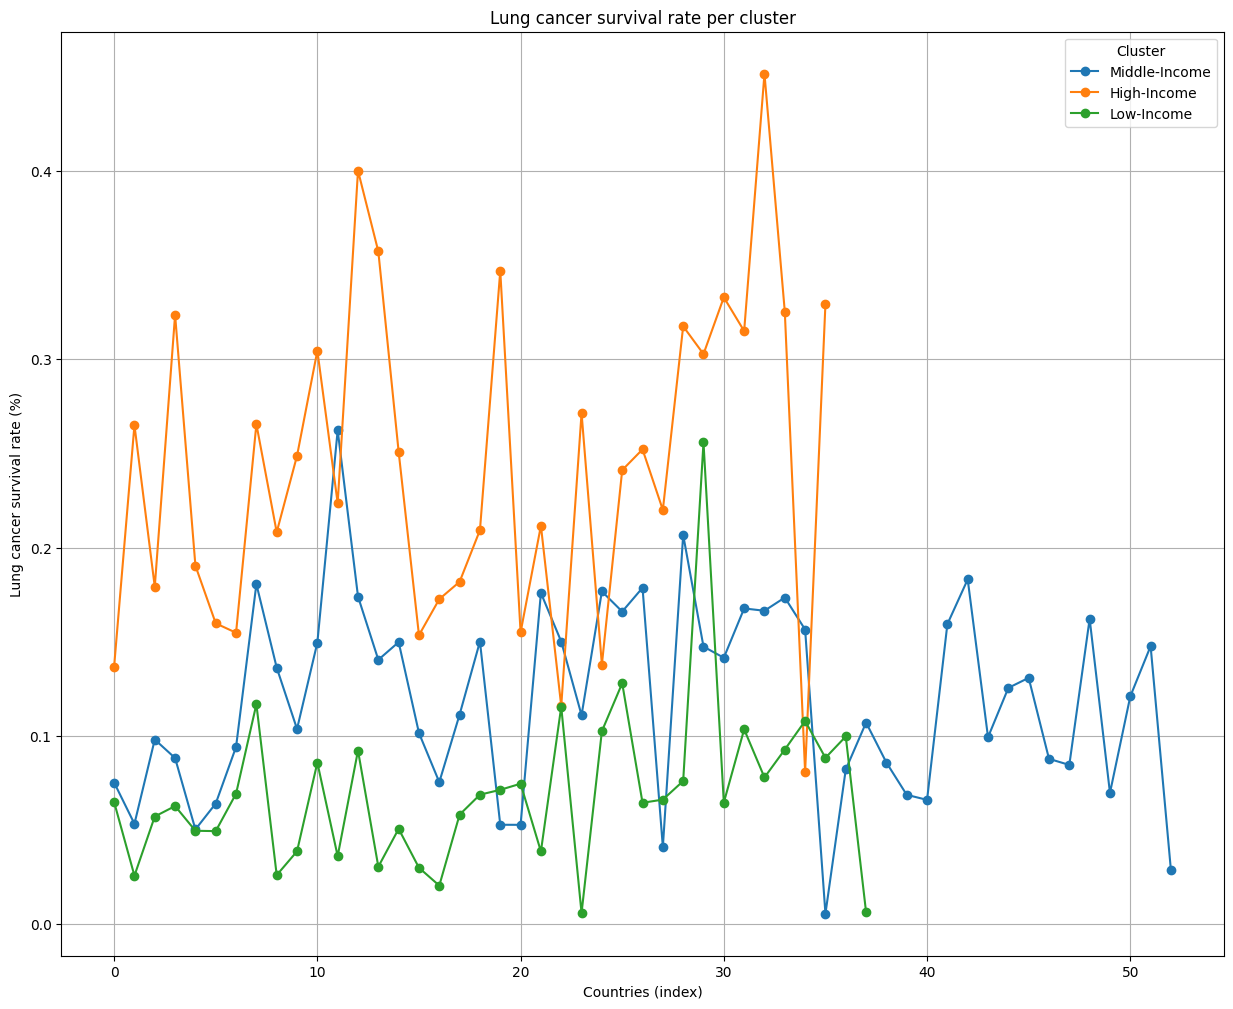

In [111]:
import matplotlib.pyplot as plt

# Création de la figure
plt.figure(figsize=(15, 12))

# Liste des clusters et leurs taux de survie respectifs
clusters = ["Middle-Income", "High-Income", "Low-Income"]
survival_rates = [
    cluster_1_df["Lung Cancer AS 3-year survival rate"].values,
    cluster_2_df["Lung Cancer AS 3-year survival rate"].values,
    cluster_3_df["Lung Cancer AS 3-year survival rate"].values
]

# Tracer les lignes
for i, rates in enumerate(survival_rates):
    plt.plot(rates, label=clusters[i], marker='o', linestyle='-')

# Personnalisation du graphique
plt.xlabel("Countries (index)")
plt.ylabel("Lung cancer survival rate (%)")
plt.title("Lung cancer survival rate per cluster")
plt.legend(title="Cluster")
plt.grid(True)

# Afficher le graphique
plt.show()


Apart from a few outliers, the graph depicting lung cancer survival rates shows a clear trend: high-income countries demonstrate the highest survival rates. They are followed by middle-income countries, while low-income countries exhibit the lowest survival rates. This pattern closely aligns with the trends observed in the global cancer survival rate map

#### Trends in colorectal cancer across clusters

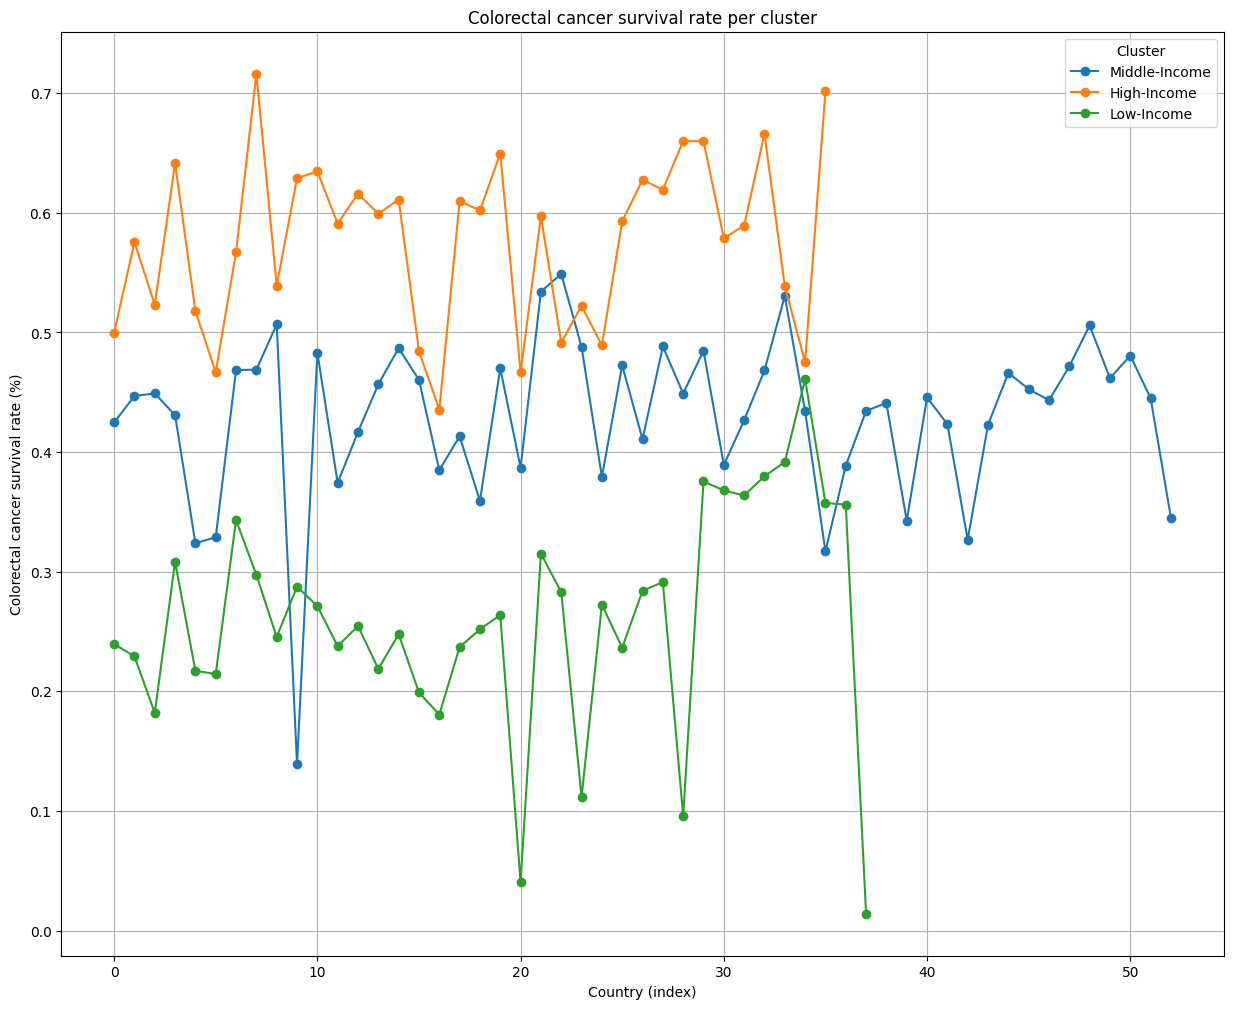

In [113]:
import matplotlib.pyplot as plt

# Création de la figure
plt.figure(figsize=(15, 12))

# Liste des clusters et leurs taux de survie respectifs
clusters = ["Middle-Income", "High-Income", "Low-Income"]
survival_rates = [
    cluster_1_df["Colorectal cancer AS 3-year survival rate"].values,
    cluster_2_df["Colorectal cancer AS 3-year survival rate"].values,
    cluster_3_df["Colorectal cancer AS 3-year survival rate"].values
]

# Tracer les lignes
for i, rates in enumerate(survival_rates):
    plt.plot(rates, label=clusters[i], marker='o', linestyle='-')

# Personnalisation du graphique
plt.xlabel("Country (index)")
plt.ylabel("Colorectal cancer survival rate (%)")
plt.title("Colorectal cancer survival rate per cluster")
plt.legend(title="Cluster")
plt.grid(True)

# Afficher le graphique
plt.show()


Apart from a few unusual cases, the graph for colorectal cancer survival shows trends similar to those in the global cancer survival rate map: high-income countries exhibit high survival rates, middle-income countries moderate rates, and low-income countries low rates.

### Findings

Lung cancer and colorectal cancer survival rates follow the same trends as global cancer survival rates in terms of country income levels. Based on this, we will use the global survival rate as the dependent variable for the rest of our analysis.

## In-sample analysis

### Identifying effects in Categorical variables

In [74]:
category.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [75]:
category

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
0,0,1,0,1,1,0,1,0,1,0,...,48,74.111641,0.75,0.075143,0.424832,9.831,14.877,2.583578,29.938,185.000000
1,0,1,0,1,0,1,0,1,1,0,...,10,37.892559,0.00,0.064779,0.239401,1.305,6.003,2.177356,3.480,54.333333
2,1,0,0,1,0,0,1,0,0,1,...,67,55.179852,0.51,0.053200,0.446879,3.132,3.915,2.220811,6.120,71.133333
3,0,1,0,1,0,1,1,0,0,1,...,1,39.604561,0.00,0.025641,0.229265,3.306,2.958,2.871422,7.900,51.283333
4,0,1,0,1,0,1,0,1,0,1,...,4,41.460030,0.00,0.057083,0.181953,2.958,5.568,2.790789,1.380,13.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,0,0,1,0,1,1,0,1,0,...,12,74.841270,0.28,0.147596,0.445059,7.308,7.830,2.345278,11.780,352.866667
123,1,0,0,1,1,0,1,0,1,0,...,11043,86.778778,1.12,0.329411,0.701833,20.967,30.102,5.672711,28.560,245.300000
124,1,0,1,0,0,1,1,0,1,0,...,121,58.247059,0.00,0.028468,0.345077,5.916,10.005,3.093556,39.500,233.916667
125,0,1,1,0,0,1,1,0,0,1,...,46,30.394680,0.08,0.099607,0.356092,9.309,10.179,3.559600,1.160,207.033333


In [76]:
# Create a new dataframe which only contains categorical variables
categorical_var = category[['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (dedicated time to cancer research)_no',
       'Available staff in Ministry of Health (dedicated time to cancer research)_yes',
       'Availability of population-based cancer registry (PBCR)_High quality PBCR',
       'Availability of population-based cancer registry (PBCR)_PBCR',
       'Availability of population-based cancer registry (PBCR)_Registration activity',
       'World Bank income level_High income (HIC)',
       'World Bank income level_Lower-middle income (LMC)',
       'World Bank income level_Upper-middle income (UMC)']]

In [77]:
# Descriptive statistics
categorical_var.describe()

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Integrated NCD plan_Under development,Integrated NCD plan_not in effect,Available staff in Ministry of Health (dedicated time to cancer research)_no,Available staff in Ministry of Health (dedicated time to cancer research)_yes,Availability of population-based cancer registry (PBCR)_High quality PBCR,Availability of population-based cancer registry (PBCR)_PBCR,Availability of population-based cancer registry (PBCR)_Registration activity,World Bank income level_High income (HIC),World Bank income level_Lower-middle income (LMC),World Bank income level_Upper-middle income (UMC)
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,...,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,0.409449,0.566929,0.173228,0.803150,0.377953,0.543307,0.818898,0.173228,0.401575,0.574803,...,0.102362,0.047244,0.094488,0.850394,0.448819,0.338583,0.165354,0.299213,0.283465,0.283465
std,0.493680,0.497463,0.379943,0.399193,0.486796,0.500094,0.386628,0.379943,0.492158,0.496331,...,0.304325,0.213001,0.293665,0.358098,0.499343,0.475102,0.372971,0.459727,0.452465,0.452465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
# Use cramer'V to perform correlation on categorical variables
import scipy.stats as ss

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))


# Create a Cramér's V correlation matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_var.columns), len(categorical_var.columns))), 
                                index=categorical_var.columns, columns=categorical_var.columns)

for col1 in categorical_var.columns:
    for col2 in categorical_var.columns:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(categorical_var[col1], categorical_var[col2])

# Display the matrix
cramers_v_matrix

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Integrated NCD plan_Under development,Integrated NCD plan_not in effect,Available staff in Ministry of Health (dedicated time to cancer research)_no,Available staff in Ministry of Health (dedicated time to cancer research)_yes,Availability of population-based cancer registry (PBCR)_High quality PBCR,Availability of population-based cancer registry (PBCR)_PBCR,Availability of population-based cancer registry (PBCR)_Registration activity,World Bank income level_High income (HIC),World Bank income level_Lower-middle income (LMC),World Bank income level_Upper-middle income (UMC)
Palliative care availability: community/home-based care_Generally available,0.000000,0.936016,0.169328,0.169326,0.484061,0.434736,0.318189,0.350182,0.065582,0.000000,...,0.036695,0.000000,0.000000,0.117685,0.448920,0.107054,0.293876,0.588011,0.242290,0.000000
Palliative care availability: community/home-based care_Generally not available,0.936016,0.000000,0.192155,0.194123,0.475773,0.451875,0.295863,0.326393,0.000000,0.000000,...,0.067584,0.000000,0.000000,0.083027,0.434029,0.055490,0.313650,0.551774,0.234536,0.000000
Cancer management guidelines_no,0.169328,0.192155,0.000000,0.897562,0.187164,0.168417,0.228036,0.242875,0.269576,0.288382,...,0.205186,0.000000,0.000000,0.000000,0.207226,0.000000,0.197896,0.163363,0.000000,0.000000
Cancer management guidelines_yes,0.169326,0.194123,0.897562,0.000000,0.182148,0.174705,0.240631,0.199944,0.289064,0.303607,...,0.170908,0.000000,0.000000,0.000000,0.210452,0.000000,0.272903,0.147874,0.000000,0.000000
Bone marrow transplantation capacity_Generally available,0.484061,0.475773,0.187164,0.182148,0.000000,0.832430,0.291094,0.324585,0.000000,0.000000,...,0.000000,0.000000,0.143618,0.243794,0.548603,0.287960,0.221217,0.567585,0.161631,0.118607
Bone marrow transplantation capacity_Generally not available,0.434736,0.451875,0.168417,0.174705,0.832430,0.000000,0.274433,0.303602,0.000000,0.000000,...,0.000000,0.000000,0.059537,0.212282,0.550174,0.257843,0.244333,0.446742,0.264948,0.000000
Pathology services_Generally available,0.318189,0.295863,0.228036,0.240631,0.291094,0.274433,0.000000,0.945895,0.154530,0.125962,...,0.114519,0.000000,0.000000,0.000000,0.267017,0.133928,0.000000,0.224077,0.000000,0.159760
Pathology services_Generally not available,0.350182,0.326393,0.242875,0.199944,0.324585,0.303602,0.945895,0.000000,0.128044,0.098321,...,0.126491,0.000000,0.000000,0.000000,0.296506,0.154853,0.000000,0.262672,0.000000,0.148290
"Palliative care included in their operational, integrated NCD plan_no",0.065582,0.000000,0.269576,0.289064,0.000000,0.000000,0.154530,0.128044,0.000000,0.935678,...,0.376806,0.217221,0.117682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Palliative care included in their operational, integrated NCD plan_yes",0.000000,0.000000,0.288382,0.303607,0.000000,0.000000,0.125962,0.098321,0.935678,0.000000,...,0.356780,0.203465,0.095816,0.061506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [79]:
#Identify higly correlated variables
# Set threshold
threshold = 0.8

# Get the upper triangle of the Cramér's V matrix (excluding diagonal)
upper = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above the threshold
highly_correlated_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > threshold]

# Convert to a DataFrame for better visualization
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2"])

# Display the pairs of highly correlated features
correlated_df

,Feature 1,Feature 2
0,Palliative care availability: community/home-b...,Palliative care availability: community/home-b...
1,Cancer management guidelines_yes,Cancer management guidelines_no
2,Bone marrow transplantation capacity_Generally...,Bone marrow transplantation capacity_Generally...
3,Pathology services_Generally not available,Pathology services_Generally available
4,"Palliative care included in their operational,...","Palliative care included in their operational,..."


### Numerical variables

In [81]:
# Identify numerical variables
numerical_var = category.drop(categorical_var.columns,axis=1)

In [82]:
# Remove the cancer types survival rate
numerical_var = numerical_var.drop(["Country","Lung Cancer AS 3-year survival rate","Colorectal cancer AS 3-year survival rate","Lung Cancer AS 3-year incidence rate","Colorectal cancer AS 3-year incidence rate"],axis =1)
numerical_var

,Population,Age standardized 3-year cancer survival rate,GDP (current US$),Investment cost per capital in cancer (US $),MPOWER measures fully implemented and achieved,"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",Public cancer centres per 10000 cancer patients,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
0,45606480,0.424289,2.476262e+11,3.10,0,3,2.8,48,74.111641,0.75,2.583578,29.938,185.000000
1,13712828,0.293590,1.967605e+10,0.57,2,0,1.2,10,37.892559,0.00,2.177356,3.480,54.333333
2,2675352,0.409095,1.939608e+10,3.10,0,3,10.2,67,55.179852,0.51,2.220811,6.120,71.133333
3,23251485,0.207794,2.032462e+10,0.70,2,2,3.4,1,39.604561,0.00,2.871422,7.900,51.283333
4,13238559,0.223301,2.642162e+09,0.55,1,0,1.0,4,41.460030,0.00,2.790789,1.380,13.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,36194172,0.348645,1.015918e+11,2.10,0,3,6.3,12,74.841270,0.28,2.345278,11.780,352.866667
123,26256970,0.763136,1.728057e+12,2.10,4,3,1.0,11043,86.778778,1.12,5.672711,28.560,245.300000
124,936375,0.422486,5.442047e+09,3.00,1,2,19.7,121,58.247059,0.00,3.093556,39.500,233.916667
125,10329931,0.353775,3.072924e+10,2.10,1,2,0.8,46,30.394680,0.08,3.559600,1.160,207.033333


In [83]:
# Summary statistics
numerical_var.describe()

,Population,Age standardized 3-year cancer survival rate,GDP (current US$),Investment cost per capital in cancer (US $),MPOWER measures fully implemented and achieved,"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",Public cancer centres per 10000 cancer patients,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
count,1.270000e+02,127.000000,1.270000e+02,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,5.493578e+07,0.436117,7.494514e+11,2.170079,1.559055,2.307087,4.748031,2297.433071,67.282768,0.655276,3.331689,21.818409,245.454331
std,1.813466e+08,0.137952,2.964821e+12,0.757101,1.225739,1.151340,7.251720,5363.794823,16.523540,0.472716,1.090769,23.173647,148.344846
min,1.802510e+05,0.201253,1.126313e+09,0.540000,0.000000,0.000000,0.100000,0.000000,29.401621,0.000000,0.861500,0.000000,10.400000
25%,5.267180e+06,0.311438,2.097332e+10,2.085000,1.000000,2.000000,1.050000,19.000000,54.909735,0.220000,2.501906,7.120000,135.950000
50%,1.245822e+07,0.424289,7.978988e+10,2.100000,2.000000,3.000000,2.600000,121.000000,72.272247,0.710000,3.046267,16.960000,245.300000
75%,3.854211e+07,0.527022,4.021654e+11,3.000000,2.000000,3.000000,6.100000,902.500000,81.058460,1.020000,4.279133,28.220000,344.733333
max,1.428628e+09,0.763136,2.772071e+13,3.100000,5.000000,3.000000,55.400000,32394.000000,91.037918,1.920000,6.316144,189.920000,827.166667


In [84]:
# Correlation matrix
cor_mat = numerical_var.corr()
cor_mat

,Population,Age standardized 3-year cancer survival rate,GDP (current US$),Investment cost per capital in cancer (US $),MPOWER measures fully implemented and achieved,"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",Public cancer centres per 10000 cancer patients,Availability of opioids* for pain management (daily doses per million inhabitants per day),UHC coverage index,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability
Population,1.000000,-0.018054,0.554912,0.070583,-0.043063,0.074661,-0.090598,0.014330,0.024280,-0.051779,-0.071211,-0.022224,0.026678
Age standardized 3-year cancer survival rate,-0.018054,1.000000,0.277241,0.393296,0.346900,0.499179,-0.046247,0.649411,0.843855,0.668342,0.711466,0.325441,0.541485
GDP (current US$),0.554912,0.277241,1.000000,0.070276,-0.018538,0.134294,-0.047778,0.508088,0.215119,0.214442,0.184996,0.090432,0.220244
Investment cost per capital in cancer (US $),0.070583,0.393296,0.070276,1.000000,0.097533,0.501375,0.134829,-0.020894,0.543114,0.457730,0.254611,0.329556,0.364652
MPOWER measures fully implemented and achieved,-0.043063,0.346900,-0.018538,0.097533,1.000000,0.152949,0.061688,0.129040,0.344843,0.328944,0.301315,0.156237,0.147012
"Palliative care included treatment services (surgery, radiotherapy, chemotherapy)",0.074661,0.499179,0.134294,0.501375,0.152949,1.000000,0.013143,0.248868,0.626763,0.587437,0.465922,0.275670,0.378284
Public cancer centres per 10000 cancer patients,-0.090598,-0.046247,-0.047778,0.134829,0.061688,0.013143,1.000000,0.068753,0.014535,0.081918,0.025807,0.047903,0.203462
Availability of opioids* for pain management (daily doses per million inhabitants per day),0.014330,0.649411,0.508088,-0.020894,0.129040,0.248868,0.068753,1.000000,0.467891,0.453598,0.498829,0.106920,0.342620
UHC coverage index,0.024280,0.843855,0.215119,0.543114,0.344843,0.626763,0.014535,0.467891,1.000000,0.741985,0.653492,0.416488,0.613368
"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",-0.051779,0.668342,0.214442,0.457730,0.328944,0.587437,0.081918,0.453598,0.741985,1.000000,0.464309,0.449047,0.417015


<Axes: >

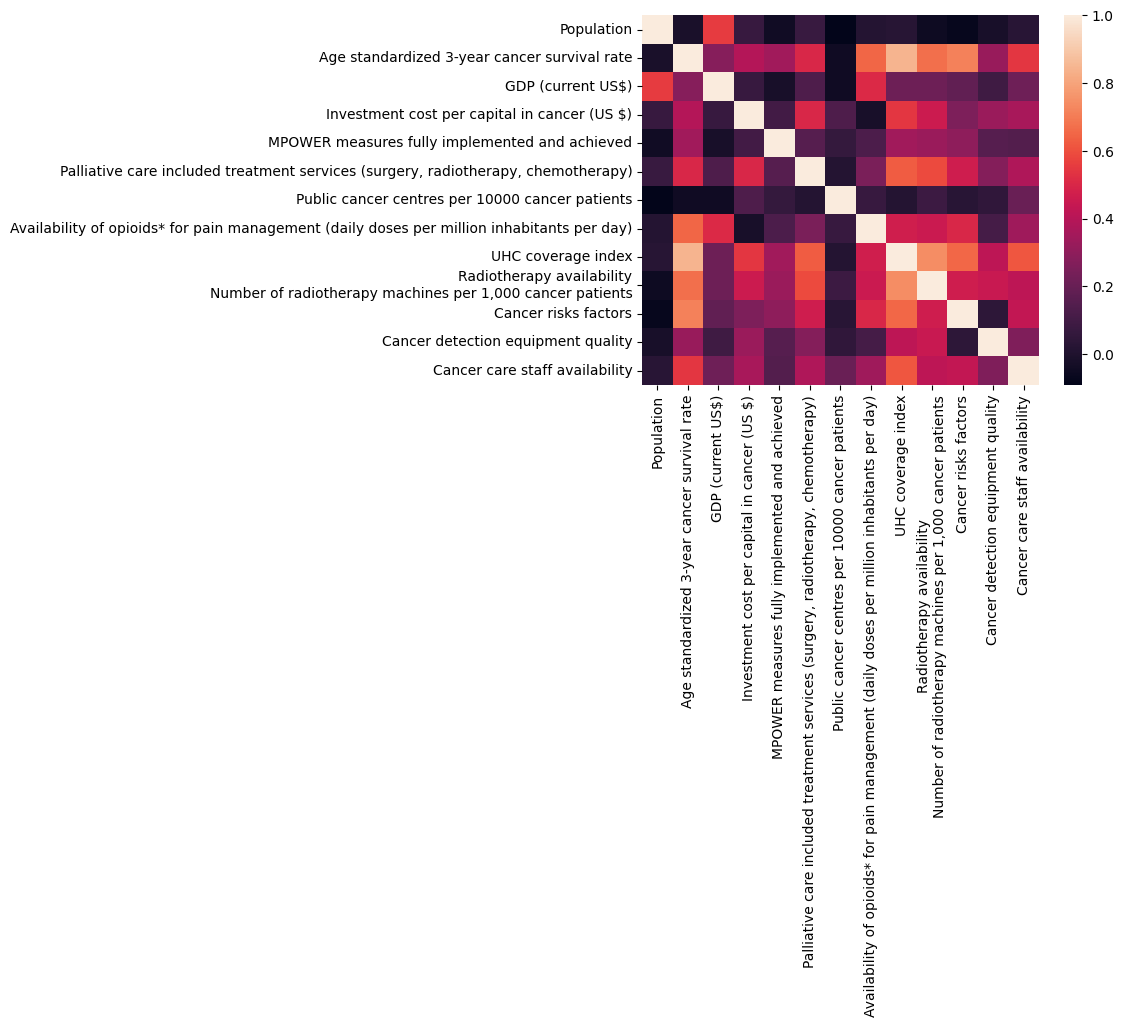

In [85]:
import seaborn as sns
# plot the heatmap
sns.heatmap(cor_mat)

In [86]:
# Identify highly correlated variables
# Set a threshold 
threshold = 0.8

# Get the upper triangle of the correlation matrix (excluding diagonal)
upper = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(bool))

# Find feature pairs with correlation above threshold
highly_correlated_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > threshold]

# Convert to a DataFrame for better visualization
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2"])
correlated_df

,Feature 1,Feature 2
0,UHC coverage index,Age standardized 3-year cancer survival rate


The correlation results highlight significant relationships between UHC coverage index and Cancer survival rate as access to comprehensive healthcare services ensures timely diagnosis and treatment, reducing financial barriers and improving patient outcomes.

In [88]:
numerical_var.columns

Index(['Population', 'Age standardized 3-year cancer survival rate',
       'GDP (current US$)', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Cancer risks factors', 'Cancer detection equipment quality',
       'Cancer care staff availability'],
      dtype='object')

#### Population

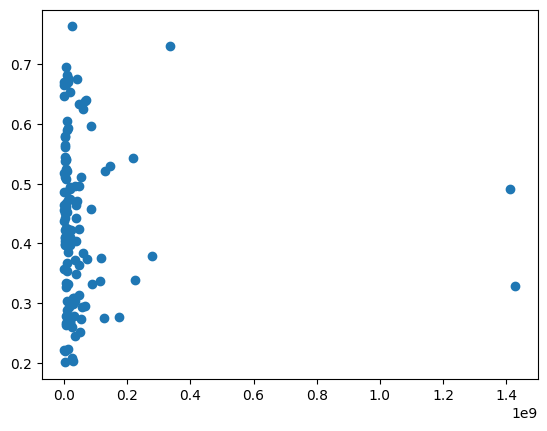

In [90]:
## Finding patterns using scatter plots
plt.scatter(numerical_var["Population"],numerical_var["Age standardized 3-year cancer survival rate"])

#### GDP (current US$)

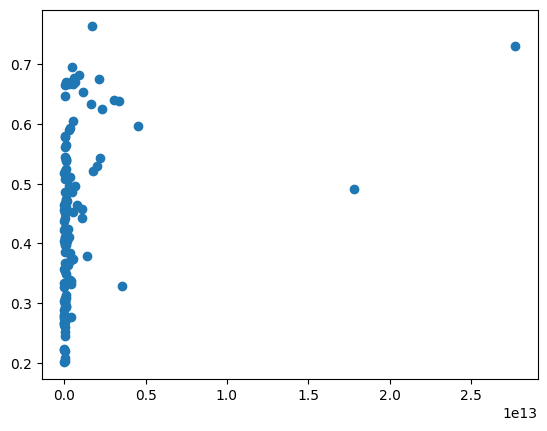

In [92]:
plt.scatter(numerical_var["GDP (current US$)"],numerical_var["Age standardized 3-year cancer survival rate"])

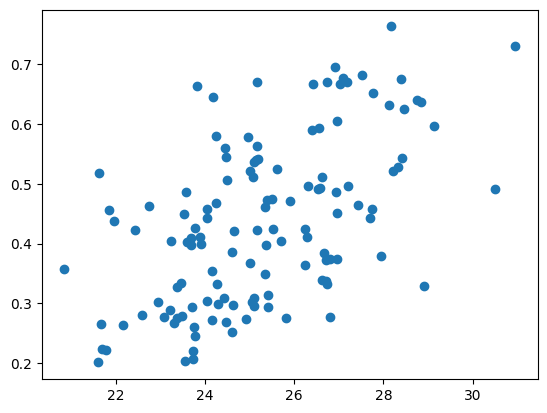

In [93]:
numerical_var["log_GDP (current US$)"]=np.log(numerical_var["GDP (current US$)"])
plt.scatter(numerical_var["log_GDP (current US$)"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Investment cost per capital in cancer (US $)

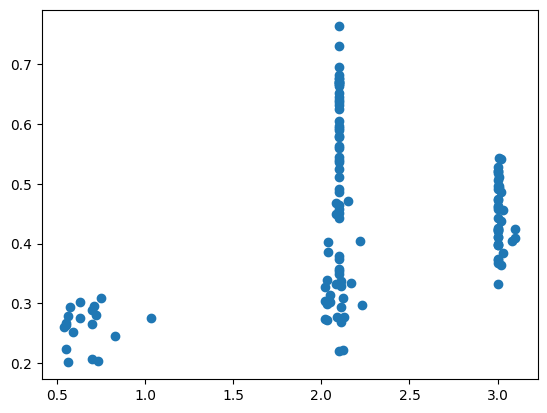

In [95]:
plt.scatter(numerical_var["Investment cost per capital in cancer (US $)"],numerical_var["Age standardized 3-year cancer survival rate"])

#### MPOWER measures fully implemented and achieved

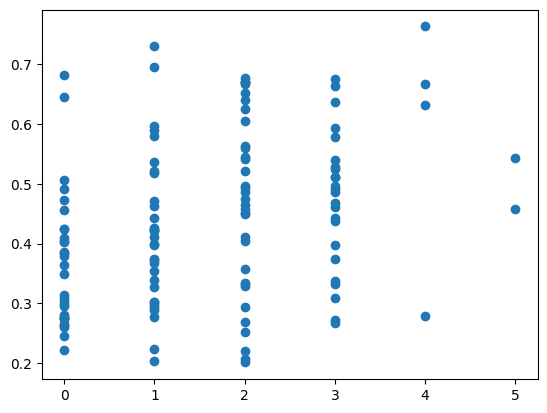

In [97]:
plt.scatter(numerical_var["MPOWER measures fully implemented and achieved"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Palliative care included treatment services (surgery, radiotherapy, chemotherapy)

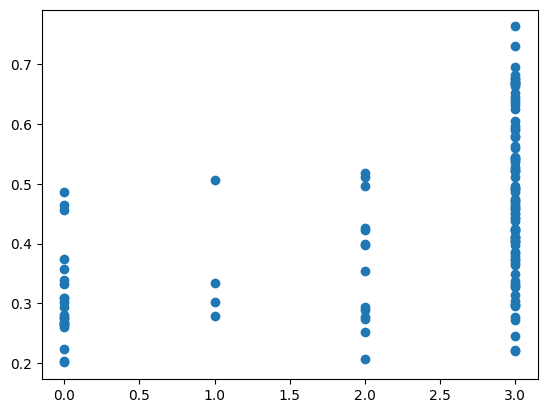

In [99]:
plt.scatter(numerical_var["Palliative care included treatment services (surgery, radiotherapy, chemotherapy)"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Public cancer centres per 10000 cancer patients

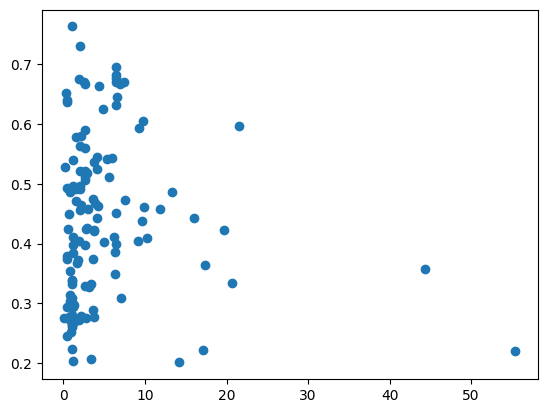

In [101]:
plt.scatter(numerical_var["Public cancer centres per 10000 cancer patients"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Availability of opioids* for pain management (daily doses per million inhabitants per day)

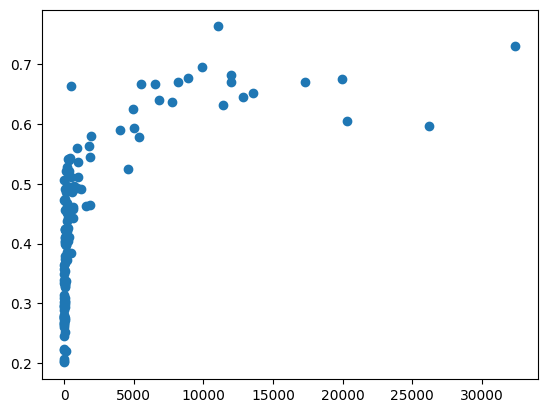

In [103]:
plt.scatter(numerical_var["Availability of opioids* for pain management (daily doses per million inhabitants per day)"],numerical_var["Age standardized 3-year cancer survival rate"])

C:\Users\Hp\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


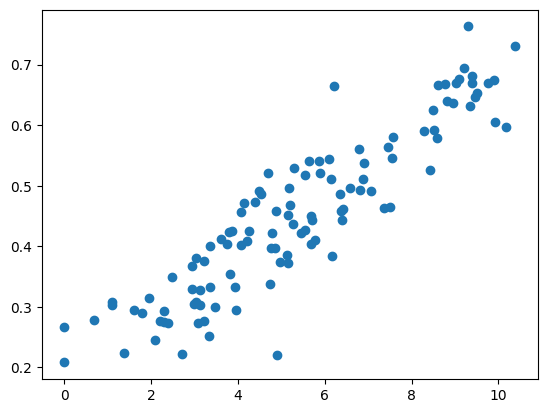

In [104]:
numerical_var["log_Availability of opioids* for pain management (daily doses per million inhabitants per day)"]=np.log(numerical_var["Availability of opioids* for pain management (daily doses per million inhabitants per day)"])
plt.scatter(numerical_var["log_Availability of opioids* for pain management (daily doses per million inhabitants per day)"],numerical_var["Age standardized 3-year cancer survival rate"])

#### UHC coverage index

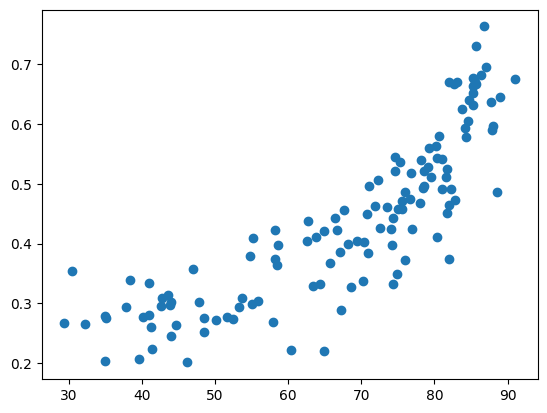

In [106]:
plt.scatter(numerical_var["UHC coverage index"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients

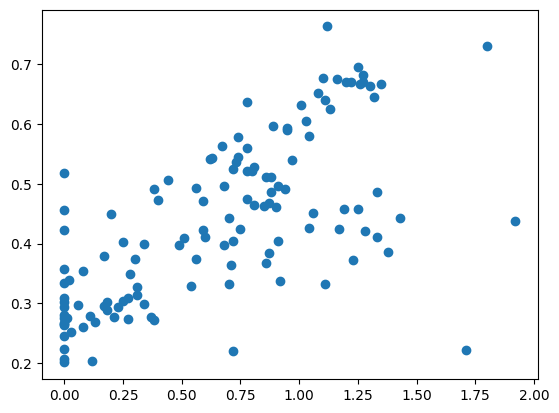

In [108]:
plt.scatter(numerical_var["Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Cancer risks factors

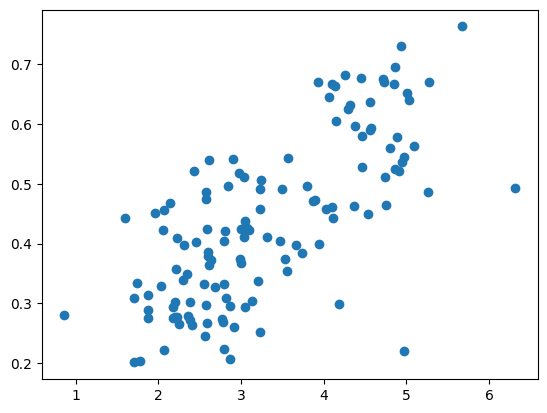

In [110]:
plt.scatter(numerical_var["Cancer risks factors"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Cancer detection equipment quality

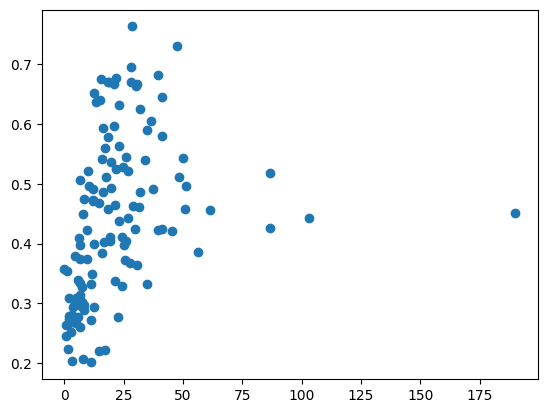

In [112]:
plt.scatter(numerical_var["Cancer detection equipment quality"],numerical_var["Age standardized 3-year cancer survival rate"])

C:\Users\Hp\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


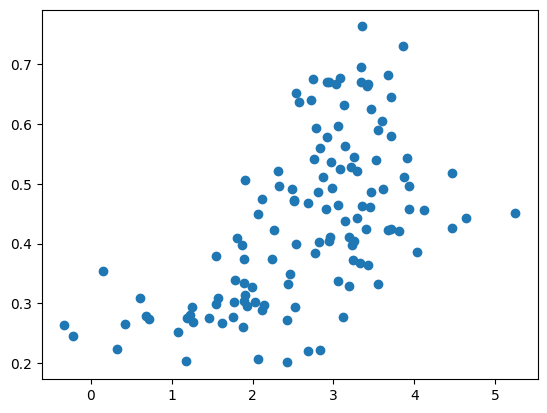

In [113]:
numerical_var["log_Cancer detection equipment quality"]=np.log(numerical_var["Cancer detection equipment quality"])
plt.scatter(numerical_var["log_Cancer detection equipment quality"],numerical_var["Age standardized 3-year cancer survival rate"])

#### Cancer care staff availability

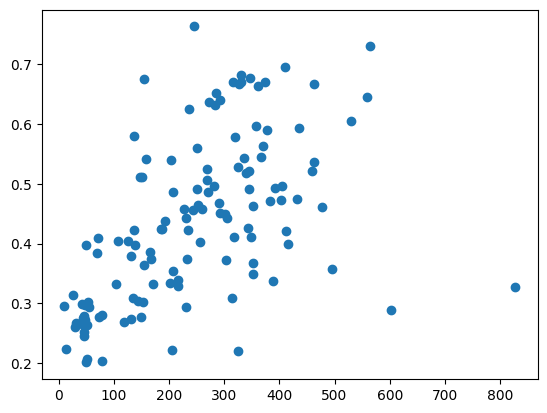

In [115]:
plt.scatter(numerical_var["Cancer care staff availability"],numerical_var["Age standardized 3-year cancer survival rate"])

In [116]:
#Transformation of availability of opioids and cancer detection equipment in the original database

# Replace 0 with a small value BEFORE log transformation to avoid having -inf in the dataset
category['Availability of opioids* for pain management (daily doses per million inhabitants per day)'] = np.where(category['Availability of opioids* for pain management (daily doses per million inhabitants per day)'] == 0, 1e-6, category['Availability of opioids* for pain management (daily doses per million inhabitants per day)'])
category['Cancer detection equipment quality'] = np.where(category['Cancer detection equipment quality'] == 0, 1e-6, category['Cancer detection equipment quality'])
category['GDP (current US$)'] = np.where(category['GDP (current US$)'] == 0, 1e-6, category['GDP (current US$)'])

category["log_Availability of opioids* for pain management (daily doses per million inhabitants per day)"] = np.log(category["Availability of opioids* for pain management (daily doses per million inhabitants per day)"])
category["log_Cancer detection equipment quality"] = np.log(category["Cancer detection equipment quality"])
category["log_GDP (current US$)"] = np.log(category["GDP (current US$)"])

#### Outliers detection

In [118]:
category.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [119]:
category3 = category.drop(["Country","Availability of opioids* for pain management (daily doses per million inhabitants per day)",
                           "Cancer detection equipment quality","GDP (current US$)"],axis = 1)

In [120]:
category3.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [121]:
category3

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,"Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer care staff availability,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$)
0,0,1,0,1,1,0,1,0,1,0,...,0.75,0.075143,0.424832,9.831,14.877,2.583578,185.000000,3.871201,3.399129,26.235186
1,0,1,0,1,0,1,0,1,1,0,...,0.00,0.064779,0.239401,1.305,6.003,2.177356,54.333333,2.302585,1.247032,23.702668
2,1,0,0,1,0,0,1,0,0,1,...,0.51,0.053200,0.446879,3.132,3.915,2.220811,71.133333,4.204693,1.811562,23.688337
3,0,1,0,1,0,1,1,0,0,1,...,0.00,0.025641,0.229265,3.306,2.958,2.871422,51.283333,0.000000,2.066863,23.735099
4,0,1,0,1,0,1,0,1,0,1,...,0.00,0.057083,0.181953,2.958,5.568,2.790789,13.216667,1.386294,0.322083,21.694863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,0,0,1,0,1,1,0,1,0,...,0.28,0.147596,0.445059,7.308,7.830,2.345278,352.866667,2.484907,2.466403,25.344228
123,1,0,0,1,1,0,1,0,1,0,...,1.12,0.329411,0.701833,20.967,30.102,5.672711,245.300000,9.309552,3.352007,28.178019
124,1,0,1,0,0,1,1,0,1,0,...,0.00,0.028468,0.345077,5.916,10.005,3.093556,233.916667,4.795791,3.676301,22.417421
125,0,1,1,0,0,1,1,0,0,1,...,0.08,0.099607,0.356092,9.309,10.179,3.559600,207.033333,3.828641,0.148420,24.148481


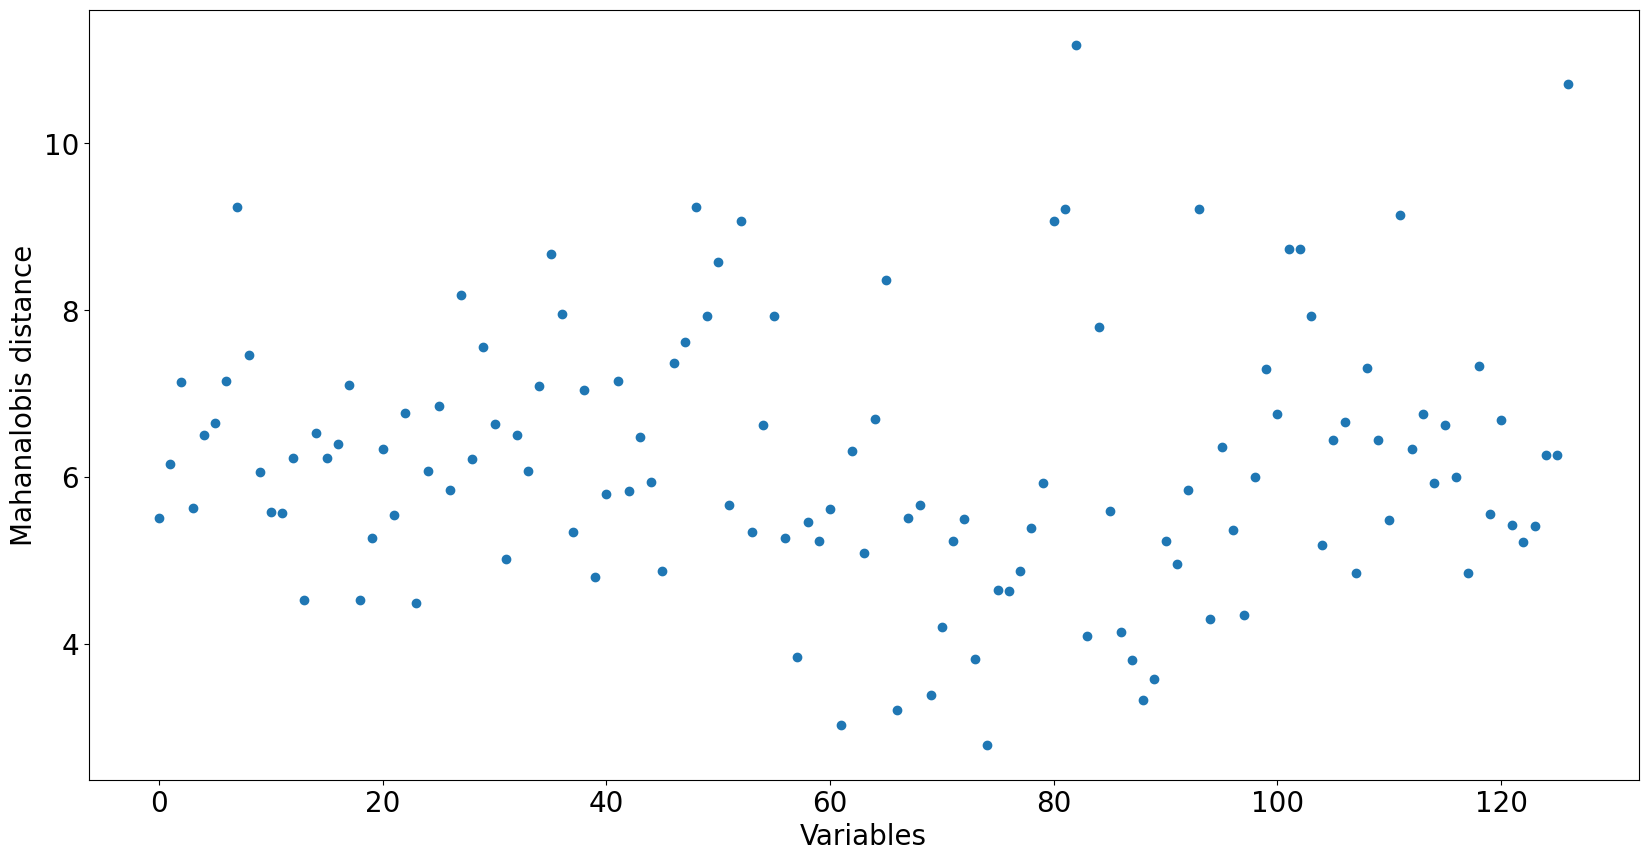

In [122]:
dist = Mahanalobis_dist(category3)

## plot
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(np.arange(np.size(category3,0)),dist)
plt.xlabel("Variables",fontsize=20)
plt.ylabel("Mahanalobis distance",fontsize=20)
plt.tick_params(axis='both',labelsize=20)

In [123]:
category3.shape

(127, 41)

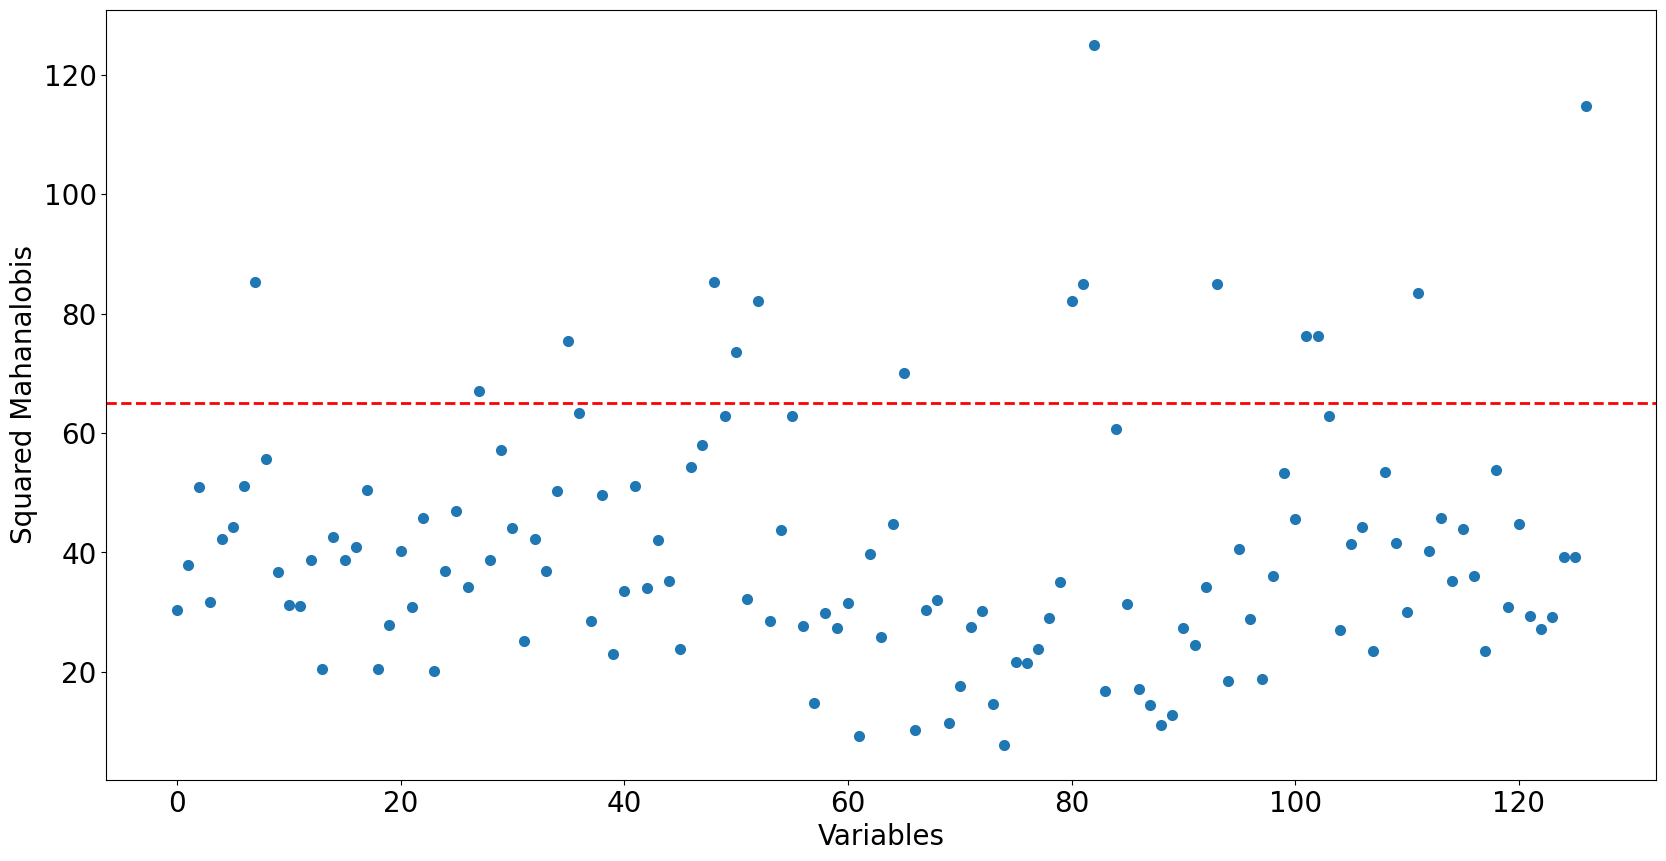

In [124]:
from scipy import stats

## Choosing a threshold
degree_chi2 = 41 #Degree of freedom = 41 since we have forty one variables.
threshold = stats.chi2.ppf(0.99,degree_chi2) ## 1% outliers 

### Plot of the distance with the threshold to select the outliers
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(np.arange(np.size(category3,0)),dist**2,linewidth = 2)
plt.axhline(y=threshold, c='red', lw=2, linestyle='dashed')
plt.xlabel("Variables",fontsize=20)
plt.ylabel("Squared Mahanalobis",fontsize=20)
plt.tick_params(axis='both',labelsize=20)

In [125]:
## Detecting the outliers
idx = (dist**2)>threshold
category3["Country"] = data["Country"]
## Printing the outliers
category3_array = category3.to_numpy()	

										

DF = pd.DataFrame({ 'Mana distance': dist[idx],'Country': category3_array[idx,-1],'Age standardized 3-year cancer survival rate':category3_array[idx,25] })

DF

,Mana distance,Country,Age standardized 3-year cancer survival rate
0,9.233853,Chad,0.266469
1,8.186960,Sudan,0.314318
2,8.679321,Argentina,0.495595
3,9.233853,Jamaica,0.397075
4,8.575465,Nicaragua,0.4026
5,9.063949,Paraguay,0.507074
6,8.368012,Cyprus,0.579861
7,9.063949,Montenegro,0.463701
8,9.216895,Norway,0.6946
9,11.180692,Poland,0.465144


In our case, removing the outliers is not a good option as it could eliminate important disparities that highlight key differences in healthcare access and cancer survival rates. Retaining these outliers helps us better understand the factors contributing to inequalities, especially in low-income regions.

In [127]:
category3.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [128]:
# Standardization
from sklearn.preprocessing import StandardScaler

# Specify the columns to standardize
columns_to_standardize = ['Population',
       'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate', 'Cancer risks factors',
       'Cancer care staff availability','log_Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'log_Cancer detection equipment quality', 'log_GDP (current US$)']

# Create the StandardScaler object
scaler = StandardScaler()

# Apply StandardScaler to selected columns only
category3[columns_to_standardize] = scaler.fit_transform(category3[columns_to_standardize])
category3

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Lung Cancer AS 3-year survival rate,Colorectal cancer AS 3-year survival rate,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer care staff availability,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$),Country
0,0,1,0,1,1,0,1,0,1,0,...,-0.710097,0.024467,-0.367421,0.026338,-0.688573,-0.409140,0.113740,0.491925,0.481395,Algeria
1,0,1,0,1,0,1,0,1,1,0,...,-0.823336,-1.269948,-1.240699,-0.904312,-1.062466,-1.293459,-0.122588,-0.725009,-0.793898,Benin
2,1,0,0,1,0,0,1,0,0,1,...,-0.949860,0.178367,-1.053568,-1.123288,-1.022469,-1.179760,0.163984,-0.405788,-0.801115,Botswana
3,0,1,0,1,0,1,1,0,0,1,...,-1.250982,-1.340705,-1.035746,-1.223652,-0.423637,-1.314100,-0.469497,-0.261424,-0.777567,Burkina Faso
4,0,1,0,1,0,1,0,1,0,1,...,-0.907427,-1.670973,-1.071390,-0.949932,-0.497853,-1.571726,-0.260637,-1.248035,-1.804963,Burundi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,0,0,1,0,1,1,0,1,0,...,0.081580,0.165663,-0.625840,-0.712707,-0.907908,0.726940,-0.095120,-0.035498,0.032738,Uzbekistan
123,1,0,0,1,1,0,1,0,1,0,...,2.068227,1.958104,0.773187,1.623040,2.154712,-0.001044,0.933083,0.465279,1.459742,Australia
124,1,0,1,0,0,1,1,0,1,0,...,-1.220103,-0.532272,-0.768416,-0.484607,-0.219182,-0.078084,0.253038,0.648656,-1.441106,Fiji
125,0,1,1,0,0,1,1,0,0,1,...,-0.442785,-0.455378,-0.420887,-0.466359,0.209773,-0.260024,0.107328,-1.346236,-0.569401,Papua New Guinea


In [129]:
# Incorporate log transformations in clusters
# Create an initial DataFrame from `y` and `countries`
data3 = pd.DataFrame(y, columns=category2.drop("Country",axis =1).columns)  # Adjust column names accordingly
data3['Country'] = countries  # Add the country column

# Add the cluster assignments to the DataFrame
data3['Cluster'] = idx_best

# Get the original Survival Rates
columns_original = ['Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'Cancer detection equipment quality', 'GDP (current US$)']

# Retrieve original values of columns that were standardized
data3[columns_original] = category[columns_original]

#Log transformation

data3['Availability of opioids* for pain management (daily doses per million inhabitants per day)'] = np.where(data3['Availability of opioids* for pain management (daily doses per million inhabitants per day)'] == 0, 1e-6, category['Availability of opioids* for pain management (daily doses per million inhabitants per day)'])
data3['Cancer detection equipment quality'] = np.where(data3['Cancer detection equipment quality'] == 0, 1e-6, data3['Cancer detection equipment quality'])
data3['GDP (current US$)'] = np.where(data3['GDP (current US$)'] == 0, 1e-6, data3['GDP (current US$)'])

data3["log_Availability of opioids* for pain management (daily doses per million inhabitants per day)"] = np.log(data3["Availability of opioids* for pain management (daily doses per million inhabitants per day)"])
data3["log_Cancer detection equipment quality"] = np.log(data3["Cancer detection equipment quality"])
data3["log_GDP (current US$)"] = np.log(data3["GDP (current US$)"])

# Standardization of logarithmic columns
# Specify the columns to standardize
columns_to_standardize = [
       'log_Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'log_Cancer detection equipment quality',"log_GDP (current US$)",
    "Availability of opioids* for pain management (daily doses per million inhabitants per day)",
    "Cancer detection equipment quality", "GDP (current US$)"
]

# Create the StandardScaler object
scaler = StandardScaler()

# Apply StandardScaler to selected columns only
data3[columns_to_standardize] = scaler.fit_transform(data3[columns_to_standardize])



# Create a DataFrame for each cluster
clustered_data = {}
for cluster in np.unique(idx_best):  # Iterate over each unique cluster index
    # Filter the rows for the current cluster
    cluster_df = data3[data3['Cluster'] == cluster]
    clustered_data[cluster] = cluster_df

# Now, `clustered_data` will be a dictionary where the keys are the cluster indices,
# and the values are DataFrames containing the countries and their corresponding features.

# Access DataFrame for clusters
cluster1 = clustered_data[0] # Upper-Middle-Income countries
cluster2 = clustered_data[1] # High-Income countries
cluster3 = clustered_data[2] # Low-Income countries
cluster1


,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$)
0,0,1,0,1,1,0,1,0,1,0,...,-0.367421,0.026338,-0.688573,0.351768,-0.409140,Algeria,0,0.113740,0.491925,0.481395
2,1,0,0,1,0,0,1,0,0,1,...,-1.053568,-1.123288,-1.022469,-0.680108,-1.179760,Botswana,0,0.163984,-0.405788,-0.801115
10,1,0,0,1,1,0,1,0,0,1,...,-0.590196,-0.949932,-0.115144,-0.022459,0.967871,Egypt,0,0.244060,0.299428,0.717820
18,0,1,0,1,1,0,1,0,0,1,...,0.443480,-0.411615,-0.491052,0.177695,-0.815092,Morocco,0,0.093622,0.410434,0.209864
20,0,1,0,1,0,0,1,0,0,1,...,-0.857526,-0.740079,0.124900,-0.118637,-0.933866,Namibia,0,0.387814,0.237190,-1.028391
26,1,0,0,1,0,0,1,0,0,1,...,0.238527,-0.302127,0.371060,-0.249474,-1.188671,South Africa,0,0.459070,0.139755,0.697974
31,0,1,0,1,1,0,1,0,0,1,...,0.416747,-0.448111,-0.673877,1.492992,-0.543479,Tunisia,0,0.304264,0.848852,-0.339292
35,0,0,0,1,0,0,1,0,1,0,...,0.398925,0.674142,0.431582,1.276375,1.076832,Argentina,0,0.521944,0.796242,0.964314
37,1,0,0,1,1,0,1,0,0,1,...,-0.073358,0.272686,0.214262,1.220055,0.608278,Brazil,0,0.448902,0.781722,1.575269
38,1,0,0,1,0,1,1,0,0,1,...,-0.242667,0.318306,-0.091070,0.667249,0.030651,Chile,0,0.596547,0.615036,0.634379


## Linear regression on the entire database

In [131]:
category3.columns

Index(['Palliative care availability: community/home-based care_Generally available',
       'Palliative care availability: community/home-based care_Generally not available',
       'Cancer management guidelines_no', 'Cancer management guidelines_yes',
       'Bone marrow transplantation capacity_Generally available',
       'Bone marrow transplantation capacity_Generally not available',
       'Pathology services_Generally available',
       'Pathology services_Generally not available',
       'Palliative care included in their operational, integrated NCD plan_no',
       'Palliative care included in their operational, integrated NCD plan_yes',
       'NCCP (including cancer types)_Operational',
       'NCCP (including cancer types)_Under development',
       'NCCP (including cancer types)_not in effect',
       'Integrated NCD plan_Operational',
       'Integrated NCD plan_Under development',
       'Integrated NCD plan_not in effect',
       'Available staff in Ministry of Health (

In [132]:
category3["Availability of opioids* for pain management (daily doses per million inhabitants per day)"] = category2["Availability of opioids* for pain management (daily doses per million inhabitants per day)"]
category3["Cancer detection equipment quality"] = category2["Cancer detection equipment quality"] 
category3["GDP (current US$)"] = category2["GDP (current US$)"]

In [133]:
# Creation of interactions terms
data_num = category3[['Population',
       'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
      'Cancer risks factors',
       'Cancer care staff availability',"Availability of opioids* for pain management (daily doses per million inhabitants per day)",
                "Cancer detection equipment quality","GDP (current US$)"]].copy()

In [134]:
from sklearn.preprocessing import PolynomialFeatures
# Generate polynomial features (quadratic terms and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)  # For quadratic terms
X_poly = poly.fit_transform(data_num)

# We add the names of each interaction variable
feature_names = poly.get_feature_names_out(input_features=data_num.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)


In [135]:
category4 = pd.concat([category3,X_poly_df],axis=1)

In [136]:
category4 = category4.drop(["Age standardized 3-year cancer survival rate",'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate',"Country"],axis =1)

In [137]:
# Check for duplicate column names
duplicate_cols = category4.columns[category4.columns.duplicated()]
print("Duplicate columns:", duplicate_cols)

Duplicate columns: Index(['Population', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Cancer risks factors', 'Cancer care staff availability',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'Cancer detection equipment quality', 'GDP (current US$)'],
      dtype='object')


In [138]:
# Remove duplicate columns
category4 = category4.loc[:, ~category4.columns.duplicated()]

In [139]:
from sklearn.model_selection import train_test_split
# Divide the dataset into training and testing set
X= category4

y = category["Age standardized 3-year cancer survival rate"]   # target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=1)


#### Stepwise regression

In [141]:

# Determining significant factors
# Stepwise regression

import statsmodels.api as sm

try :
    X= X_train
    y = y_train
    bidirectional=BidirectionalStepwiseSelection(X,y,model_type="linear",elimination_criteria = "aic",varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
    bidirectional[1].summary()
except Exception as e:
    print(f"An error occurred: {e}")

No categorical variables found. Skipping dummy transformation.
break : No need to Backward Elimination
Entered : UHC coverage index 	AIC : -211.0439722890177


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipyk

break : No need to Backward Elimination
Entered : UHC coverage index Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients 	AIC : -252.2008299427568
break : No need to Backward Elimination
Entered : Investment cost per capital in cancer (US $) Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients 	AIC : -265.4784717145162


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipyk

break : No need to Backward Elimination
Entered : World Bank income level_Lower-middle income (LMC) 	AIC : -278.96605493503193
break : No need to Backward Elimination
Entered : Public cancer centres per 10000 cancer patients Cancer risks factors 	AIC : -282.0683868300515


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipyk

break : No need to Backward Elimination
Entered : Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients 	AIC : -285.93787499761197
break : No need to Backward Elimination
Entered : Cancer risks factors Availability of opioids* for pain management (daily doses per million inhabitants per day) 	AIC : -288.24401842080533


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipyk

break : No need to Backward Elimination
Entered : Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients^2 	AIC : -292.81838099675997
break : No need to Backward Elimination
Entered : Availability of opioids* for pain management (daily doses per million inhabitants per day)^2 	AIC : -295.69276987783746


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\Ap

break : No need to Backward Elimination
Entered : Availability of opioids* for pain management (daily doses per million inhabitants per day) 	AIC : -300.7435288760581
break : No need to Backward Elimination
Entered : Cancer detection equipment quality 	AIC : -303.8977412347897


C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6560\1066475323.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns=["Cols", "Pval"])], ignore_index=True)


break : No need to Backward Elimination
Entered : Available staff in Ministry of Health (dedicated time to cancer research)_no 	AIC : -306.5704671764041
Break : Significance Level
                                         OLS Regression Results                                         
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared:                       0.933
Model:                                                      OLS   Adj. R-squared:                  0.923
Method:                                           Least Squares   F-statistic:                     95.53
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):           7.82e-40
Time:                                                  17:09:33   Log-Likelihood:                 165.29
No. Observations:                                            88   AIC:                            -306.6
Df Residuals:                                                76   BIC:               

In [142]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression 

lm = LinearRegression()

### LOO-CV for Model 1
scores_loo_SE_M1 = cross_val_score(lm,X_test[['UHC coverage index', 
                                              'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 
                                              'Available staff in Ministry of Health (dedicated time to cancer research)_no']], y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M1 = np.sqrt(-1*scores_loo_SE_M1) 

### Computing the RMSE 
RMSE_M1 = np.sqrt(np.mean(-1*scores_loo_SE_M1))

### Computing the MAE
MAE_M1 = np.mean(scores_loo_AE_M1)

results_df = pd.DataFrame({
    'Model': ['Stepwise Regression'],
    'MAE': [MAE_M1],
    'RMSE': [RMSE_M1]
})
results_df

,Model,MAE,RMSE
0,Stepwise Regression,0.067421,0.144361


#### Lasso

In [144]:
#Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


# Define a range of alpha values to try
#alpha_values = np.linspace(0.001, 10, num=100)
alpha_values =[0.0001,0.001, 0.01, 0.1, 1, 10]

# Create a Lasso model
lasso = Lasso()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(lasso, param_grid={'alpha': alpha_values}, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best model (with the best lambda)
best_lasso_reg = grid_search.best_estimator_

# Get the coefficients of the best model
best_lasso_coef = best_lasso_reg.coef_

# Create a DataFrame with the coefficients and feature names
lasso_df = pd.DataFrame(best_lasso_coef, index=X_train.columns, columns=['Lasso'])

print(lasso_df)
print("Best lambda:", grid_search.best_params_['alpha'])

                                                    Lasso
Palliative care availability: community/home-ba...    0.0
Palliative care availability: community/home-ba...   -0.0
Cancer management guidelines_no                      -0.0
Cancer management guidelines_yes                     -0.0
Bone marrow transplantation capacity_Generally ...    0.0
...                                                   ...
Availability of opioids* for pain management (d...   -0.0
Cancer detection equipment quality^2                  0.0
Cancer detection equipment quality GDP (current...   -0.0
GDP (current US$)^2                                   0.0
intercept                                             0.0

[118 rows x 1 columns]
Best lambda: 0.01


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.444e-03, tolerance: 1.453e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e-03, tolerance: 1.389e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.797e-04, tolerance: 1.304e

In [145]:
# Non zeros coefficients
non_zero_df = lasso_df[lasso_df['Lasso'] != 0]
print("Coefficients non nuls :")
non_zero_df

Coefficients non nuls :


,Lasso
MPOWER measures fully implemented and achieved,0.003192
UHC coverage index,0.076198
Cancer risks factors,0.023026
Availability of opioids* for pain management (daily doses per million inhabitants per day),0.023883
Investment cost per capital in cancer (US $)^2,-0.002593
"Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",-0.004744
"Palliative care included treatment services (surgery, radiotherapy, chemotherapy) Public cancer centres per 10000 cancer patients",-0.005304
Public cancer centres per 10000 cancer patients^2,-0.003232
"Public cancer centres per 10000 cancer patients Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients",-0.000175
UHC coverage index^2,0.001823


In [146]:
### LOO-CV for Model 2
scores_loo_SE_M2 = cross_val_score(lasso,X_test, y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M2 = np.sqrt(-1*scores_loo_SE_M2) 

### Computing the RMSE 
RMSE_M2 = np.sqrt(np.mean(-1*scores_loo_SE_M2))

### Computing the MAE
MAE_M2 = np.mean(scores_loo_AE_M2)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['Lasso',MAE_M2, RMSE_M2]


# Display final results
print(results_df)

                 Model       MAE      RMSE
0  Stepwise Regression  0.067421  0.144361
1                Lasso  0.099557  0.125897


Based on the cross-validation results, we will use the significant variables selected through stepwise regression to perform linear regression, as it has the lowest MAE.

#### Linear regression

In [149]:
X = X_train[['UHC coverage index', 'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 'Available staff in Ministry of Health (dedicated time to cancer research)_no']]
y = y_train
X = sm.add_constant(X)
model3 = sm.OLS(y, X).fit()
# Print out the statistics
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared:                       0.933
Model:                                                      OLS   Adj. R-squared:                  0.923
Method:                                           Least Squares   F-statistic:                     95.53
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):           7.82e-40
Time:                                                  17:09:34   Log-Likelihood:                 165.29
No. Observations:                                            88   AIC:                            -306.6
Df Residuals:                                                76   BIC:                            -276.8
Df Model:                                                    11                                         
Covariance Type:                                      nonrobust                                         
====================================================================================================================================================================================================
                                                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                0.4600      0.012     38.639      0.000       0.436       0.484
UHC coverage index                                                                                                                   0.0868      0.010      8.306      0.000       0.066       0.108
UHC coverage index Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients                               0.0475      0.009      5.175      0.000       0.029       0.066
Investment cost per capital in cancer (US $) Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients    -0.0311      0.007     -4.667      0.000      -0.044      -0.018
World Bank income level_Lower-middle income (LMC)                                                                                   -0.0457      0.012     -3.914      0.000      -0.069      -0.022
Public cancer centres per 10000 cancer patients Cancer risks factors                                                                -0.0117      0.003     -3.706      0.000      -0.018      -0.005
Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients                                         0.0207      0.009      2.414      0.018       0.004       0.038
Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients^2                                               -0.0229      0.007     -3.405      0.001      -0.036      -0.010
Availability of opioids* for pain management (daily doses per million inhabitants per day)^2                                        -0.0152      0.004     -3.596      0.001      -0.024      -0.007
Availability of opioids* for pain management (daily doses per million inhabitants per day)                                           0.0691      0.016      4.395      0.000       0.038       0.100
Cancer detection equipment quality                                                                                                   0.0202      0.008      2.418      0.018       0.004       0.037
Available staff in Ministry of Health (

From the regression output, we can see that the significant variables to predict cancer survival rate are: the UHC coverage index, the interaction between the UHC coverage index and radiotherapy availability, the interaction between investment cost in cancer and radiotherapy availability, the World Bank income level_Lower-middle income (LMC), the interaction between public cancer centers and cancer risk factors, the interaction between investment cost in cancer and public cancer centers, the squared radiotherapy availability, the squared availability of opioids, the availability of opioids, the cancer detection equipment quality, and the absence of available staff in the Ministry of Health dedicated to research.

UHC Coverage Index
When we increase the UHC coverage index by one additional unit, it increases the cancer survival rate by 0.0868, when all other factors remain constant. This shows that if a country improves its UHC coverage, it will positively impact cancer survival outcomes.

Interaction term between the UHC coverage index and radiotherapy availability
When we increase the interaction term between the UHC coverage index and radiotherapy availability by one additional unit, it increases the cancer survival rate by 0.0475, when all other factors remain constant. This shows that the combined effect of UHC coverage and radiotherapy availability leads to better cancer outcomes.

Interaction term between investment cost in cancer and radiotherapy availability
When we increase the interaction term between investment cost in cancer and radiotherapy availability by one additional unit, it decreases the cancer survival rate by 0.0311, when all other factors remain constant. This means that the combined effect of investment cost and radiotherapy availability is not favourable for better cancer survival outcomes. This may be due to poor resource allocation or small returns on investments in terms of survival outcomes.

World Bank income level_Lower-middle income (LMC)
Being classified as a lower-middle-income country (compared to the reference group, likely high-income countries) is associated with a 0.0457 lower cancer survival rate on average, when all other factors are held constant. This shows the importance of income levels in determining cancer survival outcomes.

Interaction term between public cancer centers and cancer risk factors
When we increase the interaction term between public cancer centers and cancer risk factors by one additional unit, it decreases the cancer survival rate by 0.0117, when all other factors remain constant. This shows that having a large number of public cancer centers is not sufficient to improve survival outcomes if efforts to reduce risk factors associated with cancer are lacking.

Interaction term between investment cost in cancer and public cancer centers
When we increase the interaction term between investment cost in cancer and public cancer centers by one additional unit, it increases the cancer survival rate by 0.0207, when all other factors remain constant. This means that investing in cancer care is more effective when it results in an increased number of public cancer centers.

Squared radiotherapy availability
When we increase the squared radiotherapy availability by one additional unit, it decreases the cancer survival rate by 0.0229, when all other factors remain constant. This indicates a non-linear relationship, meaning that beyond a certain point, increased radiotherapy availability becomes less beneficial. This may suggest potential issues such as overcapacity, inefficiencies, or resource misallocation at higher levels of availability.

Squared availability of opioids
When we increase the squared availability of opioids by one additional unit, it decreases the cancer survival rate by 0.0152, when all other factors remain constant. This also indicates a non-linear relationship, where a high level of opioid availability may be linked to negative effects, possibly due to misuse, over-prescription, or systemic issues in distribution and management.

Availability of opioids
When we increase the availability of opioids by one additional unit, it increases the cancer survival rate by 0.0691, when all other factors remain constant. This means that access to opioids contributes to improved cancer survival rates, likely through better pain management and palliative care.

Cancer detection equipment quality
When we increase the quality of cancer detection equipment by one additional unit, it increases the cancer survival rate by 0.0202, when all other factors remain constant. This means that better diagnostic tools contribute to earlier and more accurate detection, which leads to improved survival outcomes.

Available staff in Ministry of Health (dedicated time to cancer research)_no
Countries with no staff dedicating time to cancer research in the Ministry of Health have a cancer survival rate that is 0.0313 higher than those which do have such staff, when all other factors are held constant. Since this result appears counterintuitive, it may suggest that underlying factors linked to this variable such as administrative inefficiencies or different health system priorities can influence survival outcomes.

In [151]:
### LOO-CV for Model 3
scores_loo_SE_M3 = cross_val_score(lm,X_test[['UHC coverage index', 
                                              'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 
                                              'Available staff in Ministry of Health (dedicated time to cancer research)_no']], y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M3 = np.sqrt(-1*scores_loo_SE_M3) 

### Computing the RMSE 
RMSE_M3 = np.sqrt(np.mean(-1*scores_loo_SE_M3))

### Computing the MAE
MAE_M3 = np.mean(scores_loo_AE_M3)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['Linear regression',MAE_M3, RMSE_M3]


# Display final results
print(results_df)

                 Model       MAE      RMSE
0  Stepwise Regression  0.067421  0.144361
1                Lasso  0.099557  0.125897
2    Linear regression  0.067421  0.144361


## Cluster-level linear regression

### Cluster 1 (Midle income countries)

In [154]:
cluster1

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$)
0,0,1,0,1,1,0,1,0,1,0,...,-0.367421,0.026338,-0.688573,0.351768,-0.409140,Algeria,0,0.113740,0.491925,0.481395
2,1,0,0,1,0,0,1,0,0,1,...,-1.053568,-1.123288,-1.022469,-0.680108,-1.179760,Botswana,0,0.163984,-0.405788,-0.801115
10,1,0,0,1,1,0,1,0,0,1,...,-0.590196,-0.949932,-0.115144,-0.022459,0.967871,Egypt,0,0.244060,0.299428,0.717820
18,0,1,0,1,1,0,1,0,0,1,...,0.443480,-0.411615,-0.491052,0.177695,-0.815092,Morocco,0,0.093622,0.410434,0.209864
20,0,1,0,1,0,0,1,0,0,1,...,-0.857526,-0.740079,0.124900,-0.118637,-0.933866,Namibia,0,0.387814,0.237190,-1.028391
26,1,0,0,1,0,0,1,0,0,1,...,0.238527,-0.302127,0.371060,-0.249474,-1.188671,South Africa,0,0.459070,0.139755,0.697974
31,0,1,0,1,1,0,1,0,0,1,...,0.416747,-0.448111,-0.673877,1.492992,-0.543479,Tunisia,0,0.304264,0.848852,-0.339292
35,0,0,0,1,0,0,1,0,1,0,...,0.398925,0.674142,0.431582,1.276375,1.076832,Argentina,0,0.521944,0.796242,0.964314
37,1,0,0,1,1,0,1,0,0,1,...,-0.073358,0.272686,0.214262,1.220055,0.608278,Brazil,0,0.448902,0.781722,1.575269
38,1,0,0,1,0,1,1,0,0,1,...,-0.242667,0.318306,-0.091070,0.667249,0.030651,Chile,0,0.596547,0.615036,0.634379


In [155]:
# Creation of interactions terms
data_num1 = cluster1[['Population',
       'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
      'Cancer risks factors',
       'Cancer care staff availability',"Availability of opioids* for pain management (daily doses per million inhabitants per day)",
                "Cancer detection equipment quality","GDP (current US$)"]].copy()

In [156]:
from sklearn.preprocessing import PolynomialFeatures
# Generate polynomial features (quadratic terms and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)  # For quadratic terms
X_poly = poly.fit_transform(data_num1)

# We add the names of each interaction variable
feature_names = poly.get_feature_names_out(input_features=data_num1.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)


In [157]:
X_poly_df.index = cluster1.index
cluster1_reg = pd.concat([cluster1, X_poly_df], axis=1)

In [158]:
cluster1_reg = cluster1_reg.drop(["Age standardized 3-year cancer survival rate",'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate',"Country"],axis =1)

In [159]:
# Check for duplicate column names
duplicate_cols = cluster1_reg.columns[cluster1_reg.columns.duplicated()]
print("Duplicate columns:", duplicate_cols)

Duplicate columns: Index(['Population', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Cancer risks factors', 'Cancer care staff availability',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'Cancer detection equipment quality', 'GDP (current US$)'],
      dtype='object')


In [160]:
# Remove duplicate columns
cluster1_reg = cluster1_reg.loc[:, ~cluster1_reg.columns.duplicated()]

In [161]:
print("data_num1 shape:", data_num1.shape)
print("cluster1 shape:", cluster1.shape)
print("X_poly_df shape:", X_poly_df.shape)

data_num1 shape: (53, 12)
cluster1 shape: (53, 46)
X_poly_df shape: (53, 90)


In [162]:
cluster1_reg

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Cancer care staff availability^2,Cancer care staff availability Availability of opioids* for pain management (daily doses per million inhabitants per day),Cancer care staff availability Cancer detection equipment quality,Cancer care staff availability GDP (current US$),Availability of opioids* for pain management (daily doses per million inhabitants per day)^2,Availability of opioids* for pain management (daily doses per million inhabitants per day) Cancer detection equipment quality,Availability of opioids* for pain management (daily doses per million inhabitants per day) GDP (current US$),Cancer detection equipment quality^2,Cancer detection equipment quality GDP (current US$),GDP (current US$)^2
0,0,1,0,1,1,0,1,0,1,0,...,0.167395,0.172262,-0.143922,0.069525,0.177270,-0.148106,0.071546,0.123741,-0.059776,0.028876
2,1,0,0,1,0,0,1,0,0,1,...,1.391835,0.492524,0.802364,0.291654,0.174288,0.283930,0.103207,0.462547,0.168133,0.061115
10,1,0,0,1,1,0,1,0,0,1,...,0.936775,-0.395551,-0.021738,-0.115841,0.167020,0.009179,0.048914,0.000504,0.002688,0.014325
18,0,1,0,1,1,0,1,0,0,1,...,0.664374,0.344097,-0.144837,0.166995,0.178217,-0.075015,0.086491,0.031575,-0.036406,0.041976
20,0,1,0,1,0,0,1,0,0,1,...,0.872105,0.349840,0.110791,0.233093,0.140337,0.044443,0.093504,0.014075,0.029612,0.062300
26,1,0,0,1,0,0,1,0,0,1,...,1.412939,0.405469,0.296542,0.148428,0.116357,0.085098,0.042594,0.062237,0.031151,0.015592
31,0,1,0,1,1,0,1,0,0,1,...,0.295370,0.216413,-0.811410,0.128994,0.158563,-0.594508,0.094512,2.229026,-0.354360,0.056335
35,0,0,0,1,0,0,1,0,1,0,...,1.159567,-0.317737,1.374442,-0.037695,0.087064,-0.376616,0.010329,1.629134,-0.044680,0.001225
37,1,0,0,1,1,0,1,0,0,1,...,0.370003,-0.211020,0.742133,0.293357,0.120349,-0.423254,-0.167307,1.488534,0.588400,0.232588
38,1,0,0,1,0,1,1,0,0,1,...,0.000939,-0.006394,0.020452,-0.004296,0.043511,-0.139183,0.029237,0.445221,-0.093523,0.019646


In [163]:
from sklearn.model_selection import train_test_split
# Divide the dataset into training and testing set
X1= cluster1_reg

y1 = cluster_1_df["Age standardized 3-year cancer survival rate"]   # target

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.30,random_state=1)

In [164]:
X = X_train1[['UHC coverage index', 'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 'Available staff in Ministry of Health (dedicated time to cancer research)_no']]
y = y_train1
X = sm.add_constant(X)
model3_cluster1 = sm.OLS(y, X).fit()
# Print out the statistics
model3_cluster1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared:                       0.542
Model:                                                      OLS   Adj. R-squared:                  0.340
Method:                                           Least Squares   F-statistic:                     2.689
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):             0.0196
Time:                                                  17:09:35   Log-Likelihood:                 64.494
No. Observations:                                            37   AIC:                            -105.0
Df Residuals:                                                25   BIC:                            -85.66
Df Model:                                                    11                                         
Covariance Type:                                      nonrobust                                         
====================================================================================================================================================================================================
                                                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                0.2621      0.347      0.755      0.457      -0.453       0.977
UHC coverage index                                                                                                                   0.0622      0.022      2.792      0.010       0.016       0.108
UHC coverage index Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients                               0.0068      0.027      0.255      0.801      -0.048       0.062
Investment cost per capital in cancer (US $) Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients    -0.0062      0.014     -0.437      0.666      -0.036       0.023
World Bank income level_Lower-middle income (LMC)                                                                                   -0.0382      0.022     -1.743      0.094      -0.083       0.007
Public cancer centres per 10000 cancer patients Cancer risks factors                                                                 0.0343      0.025      1.383      0.179      -0.017       0.085
Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients                                         0.0185      0.016      1.163      0.256      -0.014       0.051
Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients^2                                                0.0003      0.010      0.031      0.975      -0.021       0.022
Availability of opioids* for pain management (daily doses per million inhabitants per day)^2                                        -1.7387      3.086     -0.563      0.578      -8.095       4.617
Availability of opioids* for pain management (daily doses per million inhabitants per day)                                          -1.0964      2.083     -0.526      0.603      -5.386       3.193
Cancer detection equipment quality                                                                                                   0.0014      0.007      0.194      0.848      -0.014       0.017
Available staff in Ministry of Health (

From the regression output for Cluster 1, we can see that only the UHC coverage index is statistically significant in predicting cancer survival rates in middle-income countries.

UHC Coverage Index
When we increase the UHC coverage index by one additional unit, it increases the cancer survival rate by 0.0622, when all other factors remain constant. This shows that if a middle-income country improves its UHC coverage, it will positively impact cancer survival outcomes.

In this category, the factors that contribute to increasing cancer survival rates are: UHC coverage index, the interaction term between UHC coverage index and radiotherapy availability, the interaction term between public cancer center and cancer risks factors, the interaction term between investment cost and public cancer centers, the squared radiotherapy availability, cancer detection equipment quality and the abscence of available staff in ministry of health who dedicated time to research.

### Cluster 2 : High income countries

In [167]:
cluster2

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$)
57,1,0,0,1,1,0,1,0,0,1,...,1.272203,1.294575,1.301774,-0.181889,-0.656839,Uruguay,1,0.455864,0.192175,-0.105257
59,1,0,0,1,1,0,1,0,1,0,...,1.049428,0.455166,0.747387,0.630857,1.919529,Austria,1,1.024682,0.602129,0.846879
60,1,0,0,1,1,0,1,0,0,1,...,0.942496,1.449683,1.453161,-0.506814,1.443080,Belarus,1,0.416886,-0.121386,-0.141637
61,1,0,0,1,1,0,1,0,0,1,...,1.539533,1.130343,1.289102,-0.146364,0.572184,Belgium,1,1.000742,0.217897,0.963305
64,0,1,0,1,1,0,1,0,1,0,...,1.931617,2.216100,1.618458,0.053790,0.845262,Croatia,1,0.654849,0.344322,-0.060658
65,1,0,1,0,1,0,1,0,0,0,...,1.031606,0.665018,1.044599,0.831011,-0.739293,Cyprus,1,0.670524,0.669731,-0.520145
66,1,0,0,1,1,0,1,0,0,1,...,0.737543,1.248955,1.146407,-0.243408,1.285730,Czechia,1,0.813857,0.144663,0.645767
67,1,0,0,1,1,0,1,0,0,1,...,1.673198,2.854781,1.782322,0.279938,0.477548,Denmark,1,0.945101,0.459708,0.731728
68,1,0,0,1,1,0,1,0,1,0,...,0.924674,1.367567,1.348244,-0.210483,0.034825,Estonia,1,0.553162,0.170588,-0.420630
69,1,0,0,1,1,0,1,0,0,1,...,0.336548,0.911367,0.702317,0.390846,1.474324,Finland,1,0.828585,0.508710,0.570455


In [168]:
# Creation of interactions terms
data_num2 = cluster2[['Population',
       'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
      'Cancer risks factors',
       'Cancer care staff availability',"Availability of opioids* for pain management (daily doses per million inhabitants per day)",
                "Cancer detection equipment quality","GDP (current US$)"]].copy()

In [169]:
from sklearn.preprocessing import PolynomialFeatures
# Generate polynomial features (quadratic terms and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)  # For quadratic terms
X_poly = poly.fit_transform(data_num2)

# We add the names of each interaction variable
feature_names = poly.get_feature_names_out(input_features=data_num2.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

In [170]:
X_poly_df.index = cluster2.index
cluster2_reg = pd.concat([cluster2, X_poly_df], axis=1)

In [171]:
cluster2_reg = cluster2_reg.drop(["Age standardized 3-year cancer survival rate",'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate',"Country"],axis =1)

In [172]:
# Check for duplicate column names
duplicate_cols = cluster2_reg.columns[cluster2_reg.columns.duplicated()]
print("Duplicate columns:", duplicate_cols)

Duplicate columns: Index(['Population', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Cancer risks factors', 'Cancer care staff availability',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'Cancer detection equipment quality', 'GDP (current US$)'],
      dtype='object')


In [173]:
# Remove duplicate columns
cluster2_reg = cluster2_reg.loc[:, ~cluster2_reg.columns.duplicated()]

In [174]:
cluster2_reg

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Cancer care staff availability^2,Cancer care staff availability Availability of opioids* for pain management (daily doses per million inhabitants per day),Cancer care staff availability Cancer detection equipment quality,Cancer care staff availability GDP (current US$),Availability of opioids* for pain management (daily doses per million inhabitants per day)^2,Availability of opioids* for pain management (daily doses per million inhabitants per day) Cancer detection equipment quality,Availability of opioids* for pain management (daily doses per million inhabitants per day) GDP (current US$),Cancer detection equipment quality^2,Cancer detection equipment quality GDP (current US$),GDP (current US$)^2
57,1,0,0,1,1,0,1,0,0,1,...,0.431438,0.225285,0.119472,0.149514,0.117637,0.062385,0.078072,3.308369e-02,0.041403,0.051814
59,1,0,0,1,1,0,1,0,1,0,...,3.684593,6.461946,1.210949,-0.154548,11.332797,2.123731,-0.271042,3.979807e-01,-0.050792,0.006482
60,1,0,0,1,1,0,1,0,0,1,...,2.082480,-0.523583,-0.731374,-0.331114,0.131641,0.183884,0.083250,2.568609e-01,0.116288,0.052647
61,1,0,0,1,1,0,1,0,0,1,...,0.327394,1.607061,-0.083747,-0.020280,7.888486,-0.411085,-0.099548,2.142244e-02,0.005188,0.001256
64,0,1,0,1,1,0,1,0,1,0,...,0.714468,-0.087875,0.045467,-0.190357,0.010808,-0.005592,0.023413,2.893352e-03,-0.012114,0.050717
65,1,0,1,0,1,0,1,0,0,0,...,0.546554,0.050429,-0.614361,0.179136,0.004653,-0.056685,0.016528,6.905794e-01,-0.201360,0.058713
66,1,0,0,1,1,0,1,0,0,1,...,1.653101,0.651588,-0.312957,-0.176870,0.256831,-0.123356,-0.069715,5.924766e-02,0.033484,0.018924
67,1,0,0,1,1,0,1,0,0,1,...,0.228052,0.863682,0.133684,-0.055363,3.270950,0.506289,-0.209671,7.836521e-02,-0.032454,0.013440
68,1,0,0,1,1,0,1,0,1,0,...,0.001213,-0.009194,-0.007330,-0.008351,0.069694,0.055567,0.063306,4.430295e-02,0.050474,0.057504
69,1,0,0,1,1,0,1,0,0,1,...,2.173632,0.889006,0.576233,-0.226615,0.363599,0.235677,-0.092685,1.527603e-01,-0.060076,0.023626


In [175]:
from sklearn.model_selection import train_test_split
# Divide the dataset into training and testing set
X2= cluster2_reg

y2 = cluster_2_df["Age standardized 3-year cancer survival rate"]   # target

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.30,random_state=1)

In [176]:
X = X_train2[['UHC coverage index', 'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 'Available staff in Ministry of Health (dedicated time to cancer research)_no']]
y = y_train2
X = sm.add_constant(X)
model3_cluster2 = sm.OLS(y, X).fit()
# Print out the statistics
model3_cluster2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared:                       0.812
Model:                                                      OLS   Adj. R-squared:                  0.678
Method:                                           Least Squares   F-statistic:                     6.052
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):            0.00133
Time:                                                  17:09:35   Log-Likelihood:                 49.942
No. Observations:                                            25   AIC:                            -77.88
Df Residuals:                                                14   BIC:                            -64.48
Df Model:                                                    10                                         
Covariance Type:                                      nonrobust                                         
====================================================================================================================================================================================================
                                                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                0.5451      0.062      8.754      0.000       0.412       0.679
UHC coverage index                                                                                                                  -0.0244      0.088     -0.278      0.785      -0.213       0.164
UHC coverage index Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients                               0.0739      0.066      1.122      0.281      -0.067       0.215
Investment cost per capital in cancer (US $) Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients    -0.0390      0.092     -0.425      0.677      -0.236       0.158
World Bank income level_Lower-middle income (LMC)                                                                                -3.374e-16   9.05e-17     -3.730      0.002   -5.32e-16   -1.43e-16
Public cancer centres per 10000 cancer patients Cancer risks factors                                                                -0.0095      0.015     -0.612      0.551      -0.043       0.024
Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients                                         0.0407      0.065      0.629      0.539      -0.098       0.179
Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients^2                                                0.0047      0.036      0.131      0.898      -0.073       0.082
Availability of opioids* for pain management (daily doses per million inhabitants per day)^2                                        -0.0079      0.006     -1.382      0.189      -0.020       0.004
Availability of opioids* for pain management (daily doses per million inhabitants per day)                                           0.0428      0.025      1.699      0.111      -0.011       0.097
Cancer detection equipment quality                                                                                                  -0.0157      0.033     -0.482      0.637      -0.086       0.054
Available staff in Ministry of Health (

From the regression output for Cluster 2, we can see that only the World Bank income level_Lower-middle income (LMC) is statistically significant in predicting cancer survival rates in high-income countries. Although the effect is almost zero, this still suggests that at certain points, income level may play a role in improving survival rates within this category.

In this category, the factors that contribute to increasing cancer survival rates are: the interaction term between UHC coverage index and radiotherapy availability,  the squared radiotherapy availability, the availability of opioids and the abscence of available staff in ministry of health who dedicated time to research.

### Cluster 3 : Low income countries

In [179]:
cluster3

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Lung Cancer AS 3-year incidence rate,Colorectal cancer AS 3-year incidence rate,Cancer risks factors,Cancer detection equipment quality,Cancer care staff availability,Country,Cluster,log_Availability of opioids* for pain management (daily doses per million inhabitants per day),log_Cancer detection equipment quality,log_GDP (current US$)
1,0,1,0,1,0,1,0,1,1,0,...,-1.240699,-0.904312,-1.062466,-0.794482,-1.293459,Benin,2,-0.122588,-0.725009,-0.793898
3,0,1,0,1,0,1,1,0,0,1,...,-1.035746,-1.223652,-0.423637,-0.602992,-1.314100,Burkina Faso,2,-0.469497,-0.261424,-0.777567
4,0,1,0,1,0,1,0,1,0,1,...,-1.071390,-0.949932,-0.497853,-0.885461,-1.571726,Burundi,2,-0.260637,-1.248035,-1.804963
5,0,1,1,0,0,1,1,0,1,0,...,-1.098123,-0.959056,-0.692858,-0.576998,-1.341961,Cameroon,2,-2.550945,-0.220030,-0.331571
6,0,1,1,0,0,1,1,0,0,1,...,-1.196144,-1.013800,-0.992637,-0.879395,-1.369709,Central African Republic,2,-2.550945,-1.193396,-1.821758
7,0,1,1,0,0,1,0,1,1,0,...,-1.196144,-1.324016,-0.687325,-0.726031,-1.443251,Chad,2,-0.469497,-0.513337,-0.996852
8,0,1,0,1,0,1,1,0,1,0,...,-1.249610,-1.095916,-1.467899,-0.657580,-0.299277,Republic of Congo,2,-2.550945,-0.359674,-0.919877
9,0,1,0,1,0,1,0,1,0,1,...,-1.151589,-0.876940,-0.474781,-0.735562,0.467171,Côte d'Ivoire,2,-0.303979,-0.538473,-0.094711
11,0,1,0,1,0,1,0,1,0,1,...,-1.044657,-0.712707,-1.064031,-0.802280,-1.346473,Ethiopia,2,0.015460,-0.755041,0.272970
12,0,1,0,1,0,1,0,1,1,0,...,-1.151589,-1.105040,-0.878056,-0.690506,-1.298986,Ghana,2,0.002898,-0.428409,-0.110964


In [180]:
# Creation of interactions terms
data_num3 = cluster3[['Population',
       'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
      'Cancer risks factors',
       'Cancer care staff availability',"Availability of opioids* for pain management (daily doses per million inhabitants per day)",
                "Cancer detection equipment quality","GDP (current US$)"]].copy()

In [181]:
from sklearn.preprocessing import PolynomialFeatures
# Generate polynomial features (quadratic terms and interactions)
poly = PolynomialFeatures(degree=2, include_bias=False)  # For quadratic terms
X_poly = poly.fit_transform(data_num3)

# We add the names of each interaction variable
feature_names = poly.get_feature_names_out(input_features=data_num3.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

In [182]:
X_poly_df.index = cluster3.index
cluster3_reg = pd.concat([cluster3, X_poly_df], axis=1)

In [183]:
cluster3_reg = cluster3_reg.drop(["Age standardized 3-year cancer survival rate",'Lung Cancer AS 3-year survival rate',
       'Colorectal cancer AS 3-year survival rate',
       'Lung Cancer AS 3-year incidence rate',
       'Colorectal cancer AS 3-year incidence rate',"Country"],axis =1)

In [184]:
# Check for duplicate column names
duplicate_cols = cluster3_reg.columns[cluster3_reg.columns.duplicated()]
print("Duplicate columns:", duplicate_cols)

Duplicate columns: Index(['Population', 'Investment cost per capital in cancer (US $)',
       'MPOWER measures fully implemented and achieved',
       'Palliative care included treatment services (surgery, radiotherapy, chemotherapy)',
       'Public cancer centres per 10000 cancer patients', 'UHC coverage index',
       'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients',
       'Cancer risks factors', 'Cancer care staff availability',
       'Availability of opioids* for pain management (daily doses per million inhabitants per day)',
       'Cancer detection equipment quality', 'GDP (current US$)'],
      dtype='object')


In [185]:
# Remove duplicate columns
cluster3_reg = cluster3_reg.loc[:, ~cluster3_reg.columns.duplicated()]

In [186]:
cluster3_reg

,Palliative care availability: community/home-based care_Generally available,Palliative care availability: community/home-based care_Generally not available,Cancer management guidelines_no,Cancer management guidelines_yes,Bone marrow transplantation capacity_Generally available,Bone marrow transplantation capacity_Generally not available,Pathology services_Generally available,Pathology services_Generally not available,"Palliative care included in their operational, integrated NCD plan_no","Palliative care included in their operational, integrated NCD plan_yes",...,Cancer care staff availability^2,Cancer care staff availability Availability of opioids* for pain management (daily doses per million inhabitants per day),Cancer care staff availability Cancer detection equipment quality,Cancer care staff availability GDP (current US$),Availability of opioids* for pain management (daily doses per million inhabitants per day)^2,Availability of opioids* for pain management (daily doses per million inhabitants per day) Cancer detection equipment quality,Availability of opioids* for pain management (daily doses per million inhabitants per day) GDP (current US$),Cancer detection equipment quality^2,Cancer detection equipment quality GDP (current US$),GDP (current US$)^2
1,0,1,0,1,0,1,0,1,1,0,...,1.673035,0.553790,1.027629,0.319639,0.183310,0.340155,0.105804,0.631201,0.196332,0.061068
3,0,1,0,1,0,1,1,0,0,1,...,1.726859,0.564842,0.792392,0.324451,0.184755,0.259185,0.106125,0.363600,0.148879,0.060960
4,0,1,0,1,0,1,0,1,0,1,...,2.470322,0.674695,1.391701,0.397470,0.184273,0.380102,0.108557,0.784041,0.223922,0.063952
5,0,1,1,0,0,1,1,0,1,0,...,1.800859,0.577068,0.774309,0.318173,0.184916,0.248120,0.101955,0.332927,0.136804,0.056214
6,0,1,1,0,0,1,1,0,0,1,...,1.876101,0.589000,1.204515,0.346423,0.184916,0.378156,0.108759,0.773336,0.222414,0.063967
7,0,1,1,0,0,1,0,1,1,0,...,2.082975,0.620355,1.047845,0.359846,0.184755,0.312071,0.107170,0.527121,0.181021,0.062165
8,0,1,0,1,0,1,1,0,1,0,...,0.089566,0.128694,0.196798,0.074398,0.184916,0.282772,0.106900,0.432411,0.163471,0.061799
9,0,1,0,1,0,1,0,1,0,1,...,0.218249,-0.200630,-0.343633,-0.106082,0.184433,0.315892,0.097518,0.541051,0.167026,0.051562
11,0,1,0,1,0,1,0,1,0,1,...,1.812988,0.572708,1.080248,0.267073,0.180914,0.341241,0.084366,0.643653,0.159132,0.039343
12,0,1,0,1,0,1,0,1,1,0,...,1.687364,0.552996,0.896957,0.296067,0.181232,0.293958,0.097029,0.476798,0.157381,0.051948


In [187]:
from sklearn.model_selection import train_test_split
# Divide the dataset into training and testing set
X3= cluster3_reg

y3 = cluster_3_df["Age standardized 3-year cancer survival rate"]   # target

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,test_size=0.30,random_state=1)

In [188]:
X = X_train3[['UHC coverage index', 'UHC coverage index Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'Investment cost per capital in cancer (US $) Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients', 'World Bank income level_Lower-middle income (LMC)', 'Public cancer centres per 10000 cancer patients Cancer risks factors', 'Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients', 'Radiotherapy availability\nNumber of radiotherapy machines per 1,000 cancer patients^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)^2', 'Availability of opioids* for pain management (daily doses per million inhabitants per day)', 'Cancer detection equipment quality', 'Available staff in Ministry of Health (dedicated time to cancer research)_no']]
y = y_train3
X = sm.add_constant(X)
model3_cluster3 = sm.OLS(y, X).fit()
# Print out the statistics
model3_cluster3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared:                       0.809
Model:                                                      OLS   Adj. R-squared:                  0.659
Method:                                           Least Squares   F-statistic:                     5.386
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):            0.00213
Time:                                                  17:09:35   Log-Likelihood:                 60.711
No. Observations:                                            26   AIC:                            -97.42
Df Residuals:                                                14   BIC:                            -82.33
Df Model:                                                    11                                         
Covariance Type:                                      nonrobust                                         
====================================================================================================================================================================================================
                                                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                             -201.1975    170.572     -1.180      0.258    -567.038     164.643
UHC coverage index                                                                                                                   0.0686      0.089      0.767      0.456      -0.123       0.260
UHC coverage index Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients                               0.0533      0.078      0.686      0.504      -0.113       0.220
Investment cost per capital in cancer (US $) Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients    -0.0154      0.010     -1.495      0.157      -0.037       0.007
World Bank income level_Lower-middle income (LMC)                                                                                    0.0186      0.020      0.908      0.379      -0.025       0.062
Public cancer centres per 10000 cancer patients Cancer risks factors                                                                -0.0144      0.007     -1.989      0.067      -0.030       0.001
Investment cost per capital in cancer (US $) Public cancer centres per 10000 cancer patients                                         0.0271      0.011      2.562      0.023       0.004       0.050
Radiotherapy availability
Number of radiotherapy machines per 1,000 cancer patients^2                                               -0.0063      0.049     -0.129      0.899      -0.111       0.098
Availability of opioids* for pain management (daily doses per million inhabitants per day)^2                                     -1124.6623    940.903     -1.195      0.252   -3142.699     893.374
Availability of opioids* for pain management (daily doses per million inhabitants per day)                                        -952.2589    801.236     -1.188      0.254   -2670.740     766.222
Cancer detection equipment quality                                                                                                   0.0565      0.030      1.906      0.077      -0.007       0.120
Available staff in Ministry of Health (

From the regression output for Cluster 3, we can see that only the interaction term between investment cost in cancer and public cancer centers is statistically significant in predicting cancer survival rates in low-income countries.

Interaction term between investment cost in cancer and public cancer centers
When we increase the interaction term between investment cost in cancer and public cancer centers by one additional unit, it increases the cancer survival rate by 0.0271, when all other factors remain constant. This means that investing in cancer care is more effective when it leads to an increase in the number of public cancer centers in low-income countries.

In this category, the factors that contribute to increasing cancer survival rates are: the UHC coverage index, the interaction term between UHC coverage index and radiotherapy availability, the World Bank income level_Lower-middle income (LMC),  the interaction term between investment cost in cancer and public cancer centers and the cancer detection equipment quality.

## Findings

The UHC coverage index is a significant positive contributor to cancer survival rates in middle-income countries (coefficient: 0.0622). It also positively contributes in low-income countries (coefficient: 0.0686), although it is not statistically significant. In contrast, it negatively contributes to cancer survival in high-income countries (coefficient: -0.0244).

The interaction term between UHC coverage index and radiotherapy availability contributes positively across all country categories. In middle-income countries, the coefficient is 0.0068; in high-income countries, it is 0.0739; and in low-income countries, it is 0.0533.

The interaction between public cancer centers and cancer risk factors is a positive contributor in middle-income countries (coefficient: 0.0343), but it has a negative contribution in both high-income countries (coefficient: -0.0095) and low-income countries (coefficient: -0.0144).

The interaction between investment cost in cancer and public cancer centers is a positive contributor in all three country categories. In middle-income countries, the coefficient is 0.0185; in high-income countries, it is 0.0407; and in low-income countries, it is 0.0271.

The squared radiotherapy availability term is a positive contributor in middle-income countries (coefficient: 0.0003) and high-income countries (coefficient: 0.0047), but it negatively contributes to cancer survival in low-income countries (coefficient: -0.0063).

The quality of cancer detection equipment contributes positively in middle-income countries (coefficient: 0.0014) and low-income countries (coefficient: 0.0565), while it negatively contributes in high-income countries (coefficient: -0.0157).

The absence of available staff in the Ministry of Health who dedicate time to research is a positive contributor in middle-income countries (coefficient: 0.0196) and high-income countries (coefficient: 0.0213), but it negatively contributes in low-income countries (coefficient: -0.0019).

The World Bank income level for lower-middle-income countries (LMC) is a significant negative predictor in high-income countries (coefficient: -3.374e-16). It also contributes negatively in middle-income countries (coefficient: -0.0382) but contributes positively in low-income countries (coefficient: 0.0186).

The availability of opioids is a positive contributor to cancer survival in high-income countries (coefficient: 0.0428). However, it negatively contributes in both middle-income countries (coefficient: -1.0964) and low-income countries (coefficient: -952.2589).


### Interpretation 

The UHC coverage index plays a significant role in boosting cancer survival rates in middle and low income countries, highlighting its value in expanding access to care. In contrast, its negative and non-significant effect in high-income countries suggests limited added value where coverage is already widespread.

The interaction between UHC coverage and radiotherapy access positively influences survival across all income categories. However, its impact is most pronounced in high income countries, indicating better integration and effective utilization of available technologies.

The interaction between public cancer centers and cancer risk factors improve survival outcomes in middle-income countries, but shows a negative contribution in both low and high income countries possibly due to inefficiencies, overloaded systems or the greater difficulty in effectively managing risk factors in these countries.

The combined effect of investment in cancer care and the number of public cancer centers has a positive impact on cancer survival across all country groups, indicating that allocating funds where they directly expand service capacity yields survival outcomes regardless of income level.

The squared Radiotherapy availability positively influence survival rates in middle and high income countries, whereas in low income countries, it shows a negative effect, which could reflect underuse or poor integration and implementation into treatment plans.

Cancer detection equipment quality contributes positively in middle and low income countries, where diagnostic capacity is still developping. Meanwhile, the negative effect observed in high income countries may indicate limited additional benefit where detection systems are already well-established.

The lack of ministry health staff focused on cancer research appears to support better outcomes in middle- and high-income countries, potentially due to other system strengths which compensates the gap. In low-income countries, however, this absence is detrimental,  indicating reliance on limited human resources.

The lower-middle income status (LMC) variable significantly lowers cancer survival in high income countries, suggesting that countries within this group with the lowest incomes underperform. It also has a negative influence in middle-income countries, while showing a positive effect in low income countries, perhaps reflecting their relative progress.

Finally, the opioid availability is linked to improved survival outcomes in high-income countries, where it likely supports effective palliative care. Conversely, its negative impact in middle and low income countries may reflect misuse, late-stage treatment focus, or system-level gaps in pain management integration.

## Test of additional methods 

### Principal component analysis

In [196]:
X= category4

y = category["Age standardized 3-year cancer survival rate"]   # target

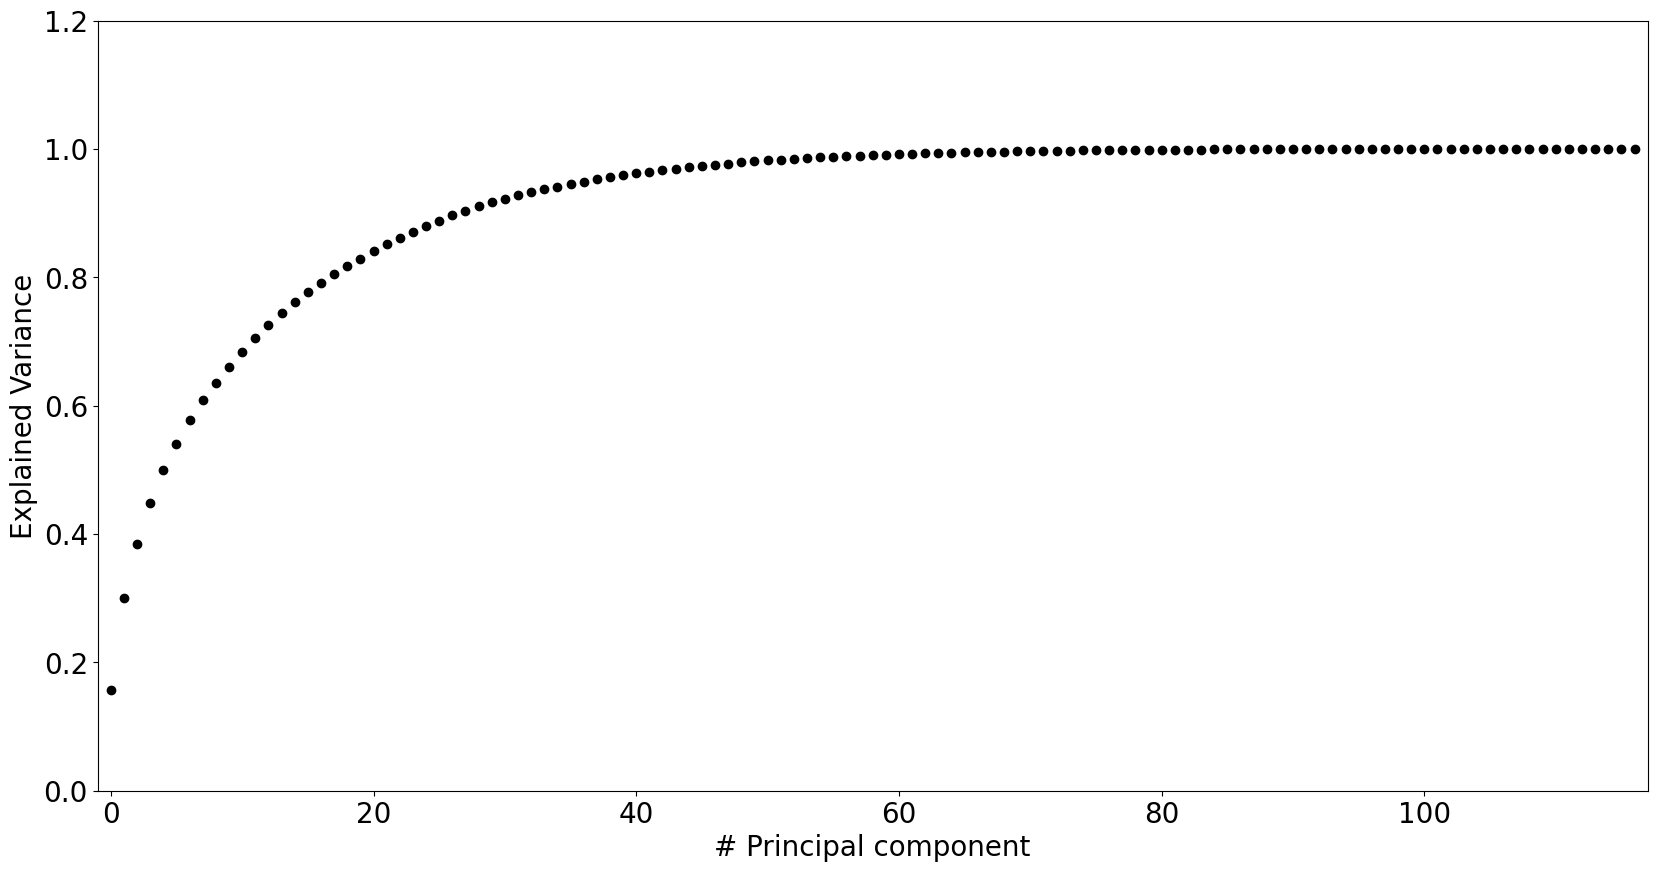

In [197]:
corr_mat = category4.corr()
corr_mat_numpy = np.corrcoef(category4.T)

#Computing the eigenvalues and the eigenvectors of the correlation matrix
Lamb,V = np.linalg.eig(corr_mat_numpy)
idx_sort = np.argsort(-1*Lamb)
Lamb_sort = Lamb[idx_sort]
V_sort = V[:,idx_sort]

###############################################
#### Computing the cumulative total variance of the PCs.
###############################################
cum_var = np.cumsum(Lamb_sort)/np.sum(Lamb_sort)


#### Plotting the cumulative total variance to find the number of PCs that captures more than 80%
###############################################
dimension = np.shape(X)[1]
func_plot(cum_var,x=np.arange(0,dimension),ylabel='Explained Variance',xlabel='# Principal component',ylim=[0,1.2])

In [198]:
# Display eignevalues
eigenvalues = pd.DataFrame(Lamb_sort)
eigenvalues

,0
0,18.401409
1,16.778484
2,9.885013
3,7.373379
4,6.011798
...,...
112,0.000025
113,0.000020
114,0.000008
115,0.000004


In [199]:
# Display the explained variance
sum_ev = eigenvalues.iloc[0:18].sum()
var = sum_ev/eigenvalues.sum()
var

0    0.804787
dtype: float64

In [200]:
# Display the first 18 eigenvectors
eigenvectors = pd.DataFrame(V_sort)
eigenvectors.iloc[:, 0:18]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.083589,-0.094608,0.100448,-0.066860,-0.132021,-0.036913,-0.032548,0.009234,-0.067074,-0.005672,0.094983,-0.010695,-0.114838,-0.154370,0.112782,-0.018599,0.099533,-0.124758
1,-0.084390,0.091684,-0.098054,0.072864,0.127313,0.042847,0.013288,-0.009270,0.045685,0.016823,-0.095090,0.018326,0.143185,0.135361,-0.083632,0.022987,-0.108400,0.107637
2,-0.103744,0.064841,-0.013695,0.075574,-0.046512,-0.019376,0.009900,-0.094831,0.007460,-0.175312,0.046496,-0.085266,0.152637,0.049257,0.259878,0.185754,-0.056167,-0.178410
3,0.092772,-0.064210,0.013445,-0.080655,0.037429,0.007678,-0.012942,0.105782,-0.001092,0.173817,-0.037764,0.073815,-0.178780,-0.056755,-0.282542,-0.186699,0.102122,0.174138
4,0.073151,-0.103389,0.102793,-0.079970,-0.163187,-0.008617,-0.053792,0.028536,-0.061264,-0.087802,0.059798,0.035586,-0.017478,-0.033196,0.070517,-0.002914,0.032142,0.035325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.107676,-0.150160,0.027532,0.088108,0.013840,0.139131,0.076748,0.064116,0.027191,-0.106864,-0.002364,-0.025637,-0.057043,-0.072756,0.029618,-0.024827,-0.036156,-0.003050
113,-0.081022,-0.202448,0.043474,0.078661,0.109925,-0.025717,0.054461,0.017230,-0.007601,-0.006452,-0.048276,0.021999,-0.009553,-0.015874,0.048194,0.001336,-0.012351,0.015505
114,0.012167,0.007140,-0.006894,-0.065769,0.131129,-0.319137,-0.196862,-0.092012,0.061828,0.068019,0.005076,0.002138,-0.021444,0.002057,0.009040,0.072069,-0.032667,0.097113
115,-0.093188,-0.172543,0.087831,0.102573,0.109208,-0.027403,0.077250,0.047819,-0.018638,-0.050327,-0.097028,0.016461,-0.050239,-0.044175,0.077942,-0.020473,-0.012375,0.013875


In [201]:
PC = np.ones([127,dimension])
for i in range(0,dimension):
    PC[:,i] = np.matmul(X.iloc[:, 0:dimension].values, V_sort[:, i-1])

In [202]:
import statsmodels.api as sm
y = category["Age standardized 3-year cancer survival rate"]
model1 = sm.OLS(y, PC[:,0:19]).fit()
x_names_PC = ['Const','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18']


# Print out the statistics
model1.summary(xname=x_names_PC)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                              OLS Regression Results                                             
=================================================================================================================
Dep. Variable:     Age standardized 3-year cancer survival rate   R-squared (uncentered):                   0.707
Model:                                                      OLS   Adj. R-squared (uncentered):              0.656
Method:                                           Least Squares   F-statistic:                              13.74
Date:                                          Mon, 14 Apr 2025   Prob (F-statistic):                    7.74e-21
Time:                                                  17:09:37   Log-Likelihood:                         -2.7935
No. Observations:                                           127   AIC:                                      43.59
Df Residuals:                                               108   BIC:                                      97.63
Df Model:                                                    19                                                  
Covariance Type:                                      nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          0.3232      0.115      2.812      0.006       0.095       0.551
PC1           -0.0250      0.014     -1.829      0.070      -0.052       0.002
PC2           -0.1348      0.034     -3.911      0.000      -0.203      -0.066
PC3           -0.0149      0.017     -0.892      0.375      -0.048       0.018
PC4           -0.0181      0.015     -1.239      0.218      -0.047       0.011
PC5           -0.0050      0.021     -0.243      0.809      -0.046       0.036
PC6           -0.0451      0.010     -4.584      0.000      -0.065      -0.026
PC7            0.0243      0.018      1.336      0.184      -0.012       0.060
PC8            0.0751      0.021      3.643      0.000       0.034       0.116
PC9           -0.0890      0.019     -4.760      0.000      -0.126      -0.052
PC10           0.0504      0.023      2.158      0.033       0.004       0.097
PC11          -0.0284      0.014     -1.999      0.048      -0.057      -0.000
PC12          -0.0210      0.016     -1.304      0.195      -0.053       0.011
PC13          -0.0305      0.026     -1.164      0.247      -0.082       0.021
PC14           0.0360      0.017      2.074      0.040       0.002       0.070
PC15           0.0396      0.031      1.282      0.203      -0.022       0.101
PC16           0.0685      0.024      2.847      0.005       0.021       0.116
PC17           0.0016      0.025      0.062      0.950      -0.049       0.052
PC18           0.0129      0.030      0.433      0.666      -0.046       0.072
==============================================================================
Omnibus:                        0.449   Durbin-Watson:                   1.191
Prob(Omnibus):                  0.799   Jarque-Bera (JB):                0.203
Skew:                          -0.082   Prob(JB):                        0.904
Kurtosis:                       3.105   Cond. No.                         44.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [203]:
lm = LinearRegression() 
### LOO-CV for Model 4
scores_loo_SE_M4 = cross_val_score(lm, PC[:,0:18], y, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 

## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M4 = np.sqrt(-1*scores_loo_SE_M4)
 

### Computing the RMSE 
RMSE_M4 = np.sqrt(np.mean(-1*scores_loo_SE_M4))

### Computing the MAE
MAE_M4 = np.mean(scores_loo_AE_M4)

# Store results in DataFrame
results_df.loc[len(results_df)] = ['PC regression',MAE_M4, RMSE_M4]


# Display final results
print(results_df)


                 Model       MAE      RMSE
0  Stepwise Regression  0.067421  0.144361
1                Lasso  0.099557  0.125897
2    Linear regression  0.067421  0.144361
3        PC regression  0.069058  0.210053


### Random forests

In [205]:
from sklearn.ensemble import RandomForestRegressor

#Create the random forest  Classifier
model5=RandomForestRegressor(n_estimators=50,max_features=2)

# Train the model using training dataset
model5.fit(X_train,y_train)

#### Feature Importance
import pandas as pd
feature_imp=pd.DataFrame({'cols':X_train.columns, 'imp':model5.feature_importances_}
                       ).sort_values('imp', ascending=False)
feature_imp

,cols,imp
31,Cancer risks factors,0.057326
36,Availability of opioids* for pain management (...,0.030992
55,Investment cost per capital in cancer (US $) U...,0.028612
57,Investment cost per capital in cancer (US $) C...,0.025710
33,log_Availability of opioids* for pain manageme...,0.025044
...,...,...
62,MPOWER measures fully implemented and achieved^2,0.000187
20,Availability of population-based cancer regist...,0.000078
7,Pathology services_Generally not available,0.000050
12,NCCP (including cancer types)_not in effect,0.000000


In [206]:
### LOO-CV for Model 5
scores_loo_SE_M5 = cross_val_score(model5,X_test, y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M5 = np.sqrt(-1*scores_loo_SE_M5) 

### Computing the RMSE 
RMSE_M5 = np.sqrt(np.mean(-1*scores_loo_SE_M5))

### Computing the MAE
MAE_M5 = np.mean(scores_loo_AE_M5)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['Random Forests',MAE_M5, RMSE_M5]


# Display final results
print(results_df)

                 Model       MAE      RMSE
0  Stepwise Regression  0.067421  0.144361
1                Lasso  0.099557  0.125897
2    Linear regression  0.067421  0.144361
3        PC regression  0.069058  0.210053
4       Random Forests  0.067101  0.078477


### XGBOOST Regressor

In [208]:
from xgboost import XGBRegressor
# Grid Search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost Classifier
xgb = XGBRegressor(random_state=42)

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearch
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb = grid_search.best_estimator_

# Feature Importances
feature_importances2 = best_xgb.feature_importances_

# Display Feature Importances
feature_importance_df2 = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances2
})

# Sort by importance
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importance:")
feature_importance_df2 

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 100, 'subsample': 0.8}
Feature Importance:


,Feature,Importance
29,UHC coverage index,0.333033
33,log_Availability of opioids* for pain manageme...,0.184772
74,Palliative care included treatment services (s...,0.078521
59,Investment cost per capital in cancer (US $) A...,0.064837
55,Investment cost per capital in cancer (US $) U...,0.039806
...,...,...
17,Available staff in Ministry of Health (dedicat...,0.000000
36,Availability of opioids* for pain management (...,0.000000
27,Palliative care included treatment services (s...,0.000000
12,NCCP (including cancer types)_not in effect,0.000000


In [209]:
### LOO-CV for Model 6
scores_loo_SE_M6 = cross_val_score(best_xgb,X_test, y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M6 = np.sqrt(-1*scores_loo_SE_M6) 

### Computing the RMSE 
RMSE_M6 = np.sqrt(np.mean(-1*scores_loo_SE_M6))

### Computing the MAE
MAE_M6 = np.mean(scores_loo_AE_M6)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['XGBoost',MAE_M6, RMSE_M6]


# Display final results
print(results_df)

                 Model       MAE      RMSE
0  Stepwise Regression  0.067421  0.144361
1                Lasso  0.099557  0.125897
2    Linear regression  0.067421  0.144361
3        PC regression  0.069058  0.210053
4       Random Forests  0.067101  0.078477
5              XGBoost  0.055237  0.066170


### Decision Tree Regressor

In [211]:
from sklearn.tree import DecisionTreeRegressor

# Grid Search for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeRegressor(random_state=42)

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearch
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_dt = grid_search.best_estimator_

# Feature Importance
feature_importances = best_dt.feature_importances_
feature_names = X_train.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
feature_df



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


,Feature,Importance
29,UHC coverage index,0.735696
55,Investment cost per capital in cancer (US $) U...,0.130401
94,UHC coverage index Cancer detection equipment ...,0.070082
39,Population^2,0.023287
75,Palliative care included treatment services (s...,0.018503
...,...,...
35,log_GDP (current US$),0.000000
34,log_Cancer detection equipment quality,0.000000
33,log_Availability of opioids* for pain manageme...,0.000000
32,Cancer care staff availability,0.000000


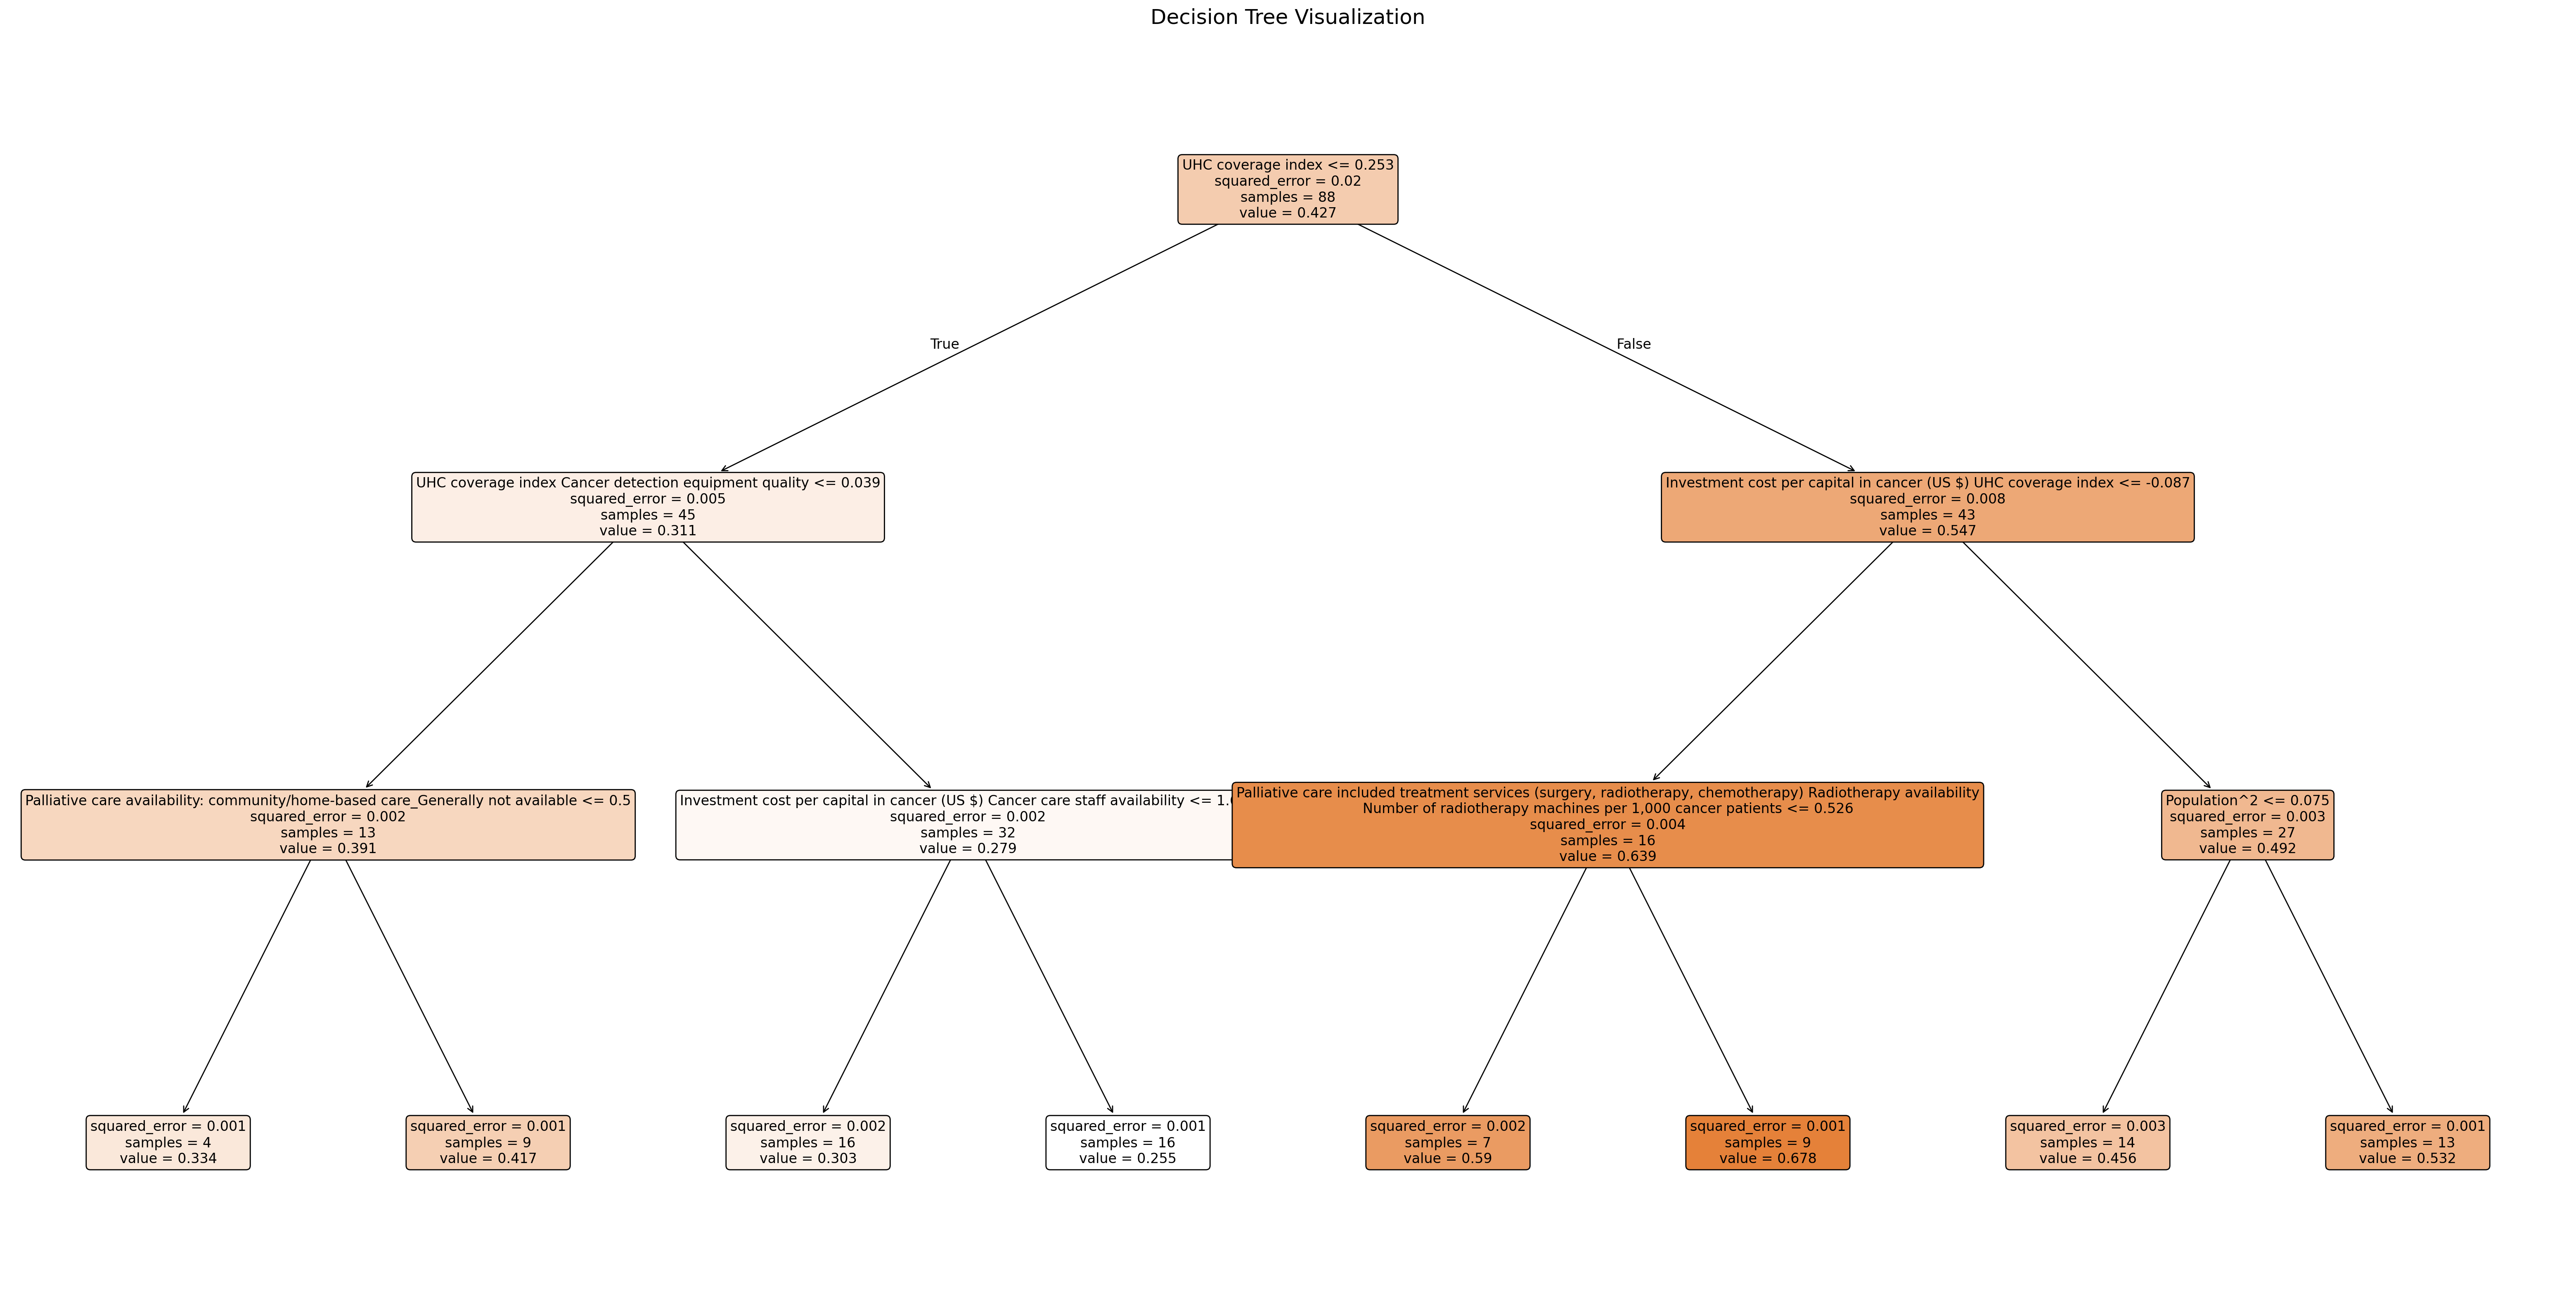

In [212]:
from sklearn.tree import plot_tree


# Increase figure size and resolution
plt.figure(figsize=(40, 20), dpi=200)  # Increase figsize and dpi for better clarity

# Plot the tree with increased font size
plot_tree(
    best_dt,
    filled=True,
    feature_names=X_train.columns,
    class_names=['Stayed', 'Left'],
    rounded=True,
    proportion=False,
    fontsize=12  # Increase font size for readability
)

plt.title("Decision Tree Visualization", fontsize=18)  # Increase title font size
plt.show()


In [213]:
### LOO-CV for Model 7
scores_loo_SE_M7 = cross_val_score(best_dt,X_test, y_test, scoring='neg_mean_squared_error', cv=LeaveOneOut()) 
## Since we have all the squared prediction errors, we can compute the absolute prediction errors without run another CV.
scores_loo_AE_M7 = np.sqrt(-1*scores_loo_SE_M7) 

### Computing the RMSE 
RMSE_M7 = np.sqrt(np.mean(-1*scores_loo_SE_M7))

### Computing the MAE
MAE_M7 = np.mean(scores_loo_AE_M7)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['Decision Tree',MAE_M7, RMSE_M7]


# Display final results
results_df

,Model,MAE,RMSE
0,Stepwise Regression,0.067421,0.144361
1,Lasso,0.099557,0.125897
2,Linear regression,0.067421,0.144361
3,PC regression,0.069058,0.210053
4,Random Forests,0.067101,0.078477
5,XGBoost,0.055237,0.066170
6,Decision Tree,0.038686,0.049396


Based on the performance evaluation, Random Forests, XGBoost, and Decision Trees outperform the regression models (Stepwise Regression, Linear Regression, and Lasso) in both MAE and RMSE. These tree-based models excel at handling non-linearities and feature interactions, making them ideal for our polynomial-enriched dataset. Stepwise Regression and Linear Regression show identical performance since the linear regression model is derived from the stepwise procedure. Lasso struggles because, while attempting to simplify complex relationships, it overly shrinks polynomial terms that are significant for our analysis. PC Regression has the highest RMSE, as incorporating polynomial terms can lead to the discarding of important components when the variance retained does not align with predictive power. Decision Tree performs the best, suggesting that our dataset predominantly contains simple, interpretable relationships.

In [215]:
# Filter to show only non-zero importance values in decision trees
non_zero_feature_df = feature_df[feature_df['Importance'] != 0]
non_zero_feature_df

,Feature,Importance
29,UHC coverage index,0.735696
55,Investment cost per capital in cancer (US $) U...,0.130401
94,UHC coverage index Cancer detection equipment ...,0.070082
39,Population^2,0.023287
75,Palliative care included treatment services (s...,0.018503
1,Palliative care availability: community/home-b...,0.011345
58,Investment cost per capital in cancer (US $) C...,0.010686


The decision tree regression identified the most important predictors of cancer survival rates as the UHC coverage index, its interaction with cancer investment cost and cancer detection equipment, squared population size, the interaction between palliative care and radiotherapy availability, the absence of community/home-based palliative care, and the interaction between cancer investment cost and cancer care staff availability. Countries with low UHC coverage, weak interaction between UHC and detection equipment, and no community-based palliative care tend to have the lowest survival rates. Introducing home-based palliative care slightly improves outcomes. In low-UHC countries, even with better detection equipment, limited investment in cancer care staff keeps survival rates low. In contrast, countries with high UHC coverage, strong investment aligned with UHC, and effective integration of palliative care and radiotherapy achieve the best outcomes. Even if the latter interaction is slightly weaker, survival remains high. However, high-UHC countries with limited UHC-aligned investment and large populations see only moderate survival rates, while smaller populations in similar conditions face lower survival.